### Machine learning framework to predict antibiotic resistance traits and yet unknown genes underlying resistance to specific antibiotics in bacterial strains

#### Jupyter Notebook by: Janak Sunuwar

Following is a computational framework that assesses different machine learning algorithms ability to predict antibiotic resistance phenotype of bacterial strains that lack known antimicrobial resistance genes yet demonstrate resistance to drugs of those families.

The machine learning algorithms' performance is evaluated in predicting resistance trait using the whole-genome sequencing antimicrobial resistance (AMR) genetic data and antimicrobial susceptibility testing (AST) phenotypic data.

In [1]:
#All set, Intersection set and Random set performance with comparision plot

def ML_run():
    import warnings
    warnings.filterwarnings('ignore')
    import pandas as pd
    import numpy as np
    np.random.seed(1)
    import sklearn
    import sklearn.model_selection
    import sklearn.metrics
    import sklearn.ensemble
    import seaborn as sns
    sns.set()
    import matplotlib.pyplot as plt
    from matplotlib import rc
    %matplotlib inline

    #Result out
    file_all_out = f"{bacteria}_{antb}_Complete_Results_{validation_no}-fold_CV.csv"

    data = pd.read_csv(file_name)

    #Split data into features and labels
    X = data.iloc[:, 1:-1] 
    Y = data.iloc[:,-1] # last column label

    #Label size and matrix size
    All_Set_Data_size = data.groupby(antb).size()
    All_Set_Matrix_size = data.shape

    #Import classifiers
    from sklearn import model_selection
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.naive_bayes import GaussianNB
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.svm import SVC
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    from sklearn.ensemble import ExtraTreesClassifier
    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.ensemble import BaggingClassifier
    from sklearn.metrics import roc_curve, roc_auc_score
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import f1_score
    from sklearn.metrics import auc
    from sklearn.metrics import precision_score, recall_score
    import pickle
    from sklearn.model_selection import StratifiedKFold
    from sklearn.model_selection import LeaveOneOut 
    from sklearn.model_selection import cross_val_score

    #Create dataframes for outputs
    Training_Performance = pd.DataFrame(columns=[])
    Test_Performance = pd.DataFrame(columns=[])
    Tf_CV = pd.DataFrame(columns=[])
    Area_Under_ROC = pd.DataFrame(columns=[])
    Area_Under_Precision_Recall = pd.DataFrame(columns=[])
    Model_Predict = pd.DataFrame(columns=[])

    #Split data into 6 equal parts
    skf = StratifiedKFold(n_splits=validation_no, random_state=42)
    i = 0
    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        #Build and evaluate models
        models = []
        models.append(('LogR', LogisticRegression()))
        models.append(('gNB', GaussianNB()))
        models.append(('SVM', SVC(kernel = 'rbf', probability=True)))
        models.append(('DT', DecisionTreeClassifier(criterion = 'entropy', random_state=1)))
        models.append(('RF', RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=0)))
        models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
        models.append(('LDA', LinearDiscriminantAnalysis()))
        models.append(('mNB', MultinomialNB()))
        models.append(('ABC', AdaBoostClassifier()))
        models.append(('GBC', GradientBoostingClassifier()))
        models.append(('ETC', ExtraTreesClassifier()))
        models.append(('BC', BaggingClassifier()))

        #Training performances
        myDF1 = pd.DataFrame(columns=[])
        for name, model in models:    
            model = model.fit(X_train, Y_train)
            Y_train_pred = model.predict(X_train)
            Tr_precision = precision_score(Y_train, Y_train_pred, average='macro').round(3)
            Tr_recall = recall_score(Y_train, Y_train_pred, average='macro').round(3)
            Tr_f1 = f1_score (Y_train, Y_train_pred, average='macro').round(3)
            myDF1 = myDF1.append({'classifier': name, f'tr_precision{i+1}': Tr_precision, f'tr_recall{i+1}': Tr_recall, f'tr_f1 {i+1}':Tr_f1}, ignore_index = True)
        Training_Performance = pd.concat([Training_Performance, myDF1], axis = 1)

        #Test performances
        myDF2 = pd.DataFrame(columns=[])
        for name, model in models:  
            model = model.fit(X_train, Y_train)
            Y_test_pred = model.predict(X_test)
            report = sklearn.metrics.classification_report(Y_test, Y_test_pred)
            Te_precision = precision_score(Y_test, Y_test_pred, average='macro').round(3)
            Te_recall = recall_score(Y_test, Y_test_pred, average='macro').round(3)
            Te_f1 = f1_score (Y_test, Y_test_pred, average='macro').round(3)
            myDF2 = myDF2.append({'classifier': name, f'te_precision{i+1}': Te_precision, f'te_recall{i+1}': Te_recall, f'te_f1 {i+1}':Te_f1}, ignore_index = True)
        Test_Performance = pd.concat([Test_Performance, myDF2], axis = 1)

        #Ten-fold cross validation
        myDF3 = pd.DataFrame(columns=[])
        for name, model in models:
            kfold = model_selection.KFold(n_splits=10, random_state=42)
            results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold)
            mean= results.mean().round(3)
            std = results.std()
            myDF3 = myDF3.append({'classifier': name, f'ten_f_CV{i+1}':mean}, ignore_index = True)
        Tf_CV = pd.concat([Tf_CV, myDF3], axis = 1)

        #AU_ROC
        myDF4 = pd.DataFrame(columns=[])
        for name, model in models:
            model = model.fit(X_train, Y_train)
            y_pred_proba = model.predict_proba(X_test)[::,1]
            fpr, tpr, _ = roc_curve(Y_test,  y_pred_proba, pos_label = None)
            a_u_c = roc_auc_score(Y_test, y_pred_proba).round(3)
            myDF4 = myDF4.append({'a classifier': name, f'au ROC {i+1}': a_u_c}, ignore_index = True)
        Area_Under_ROC = pd.concat([Area_Under_ROC, myDF4], axis = 1)

        #AUPR
        myDF5 = pd.DataFrame(columns=[])
        for name, model in models:
            #predict probabilities
            y_pred_proba = model.predict_proba(X_test)
            # keep probabilities for the positive outcome only
            y_pred_proba = y_pred_proba[:, 1]
            #predict class vlaues
            y_pred = model.predict(X_test)
            # calculate precision-recall curve
            precision, recall, _ = precision_recall_curve(Y_test, y_pred_proba)
            # calculate au precision-recall curve
            area = auc(recall, precision).round(3)
            # calculate f1 score
            f1 = f1_score(Y_test, y_pred).round(3)
            myDF5 = myDF5.append({'a classifier': name, f'au PR {i+1}': area}, ignore_index = True)
        Area_Under_Precision_Recall = pd.concat([Area_Under_Precision_Recall, myDF5], axis = 1)
        i += 1

    #Model names
    Models = Tf_CV.iloc[:, 0] 

    #Calculating the mean of all folds
    #training f1 average
    tr_f1_avg = Training_Performance[Training_Performance.columns[1::4]].mean(axis=1).round(3)
    tr_f1_avg = tr_f1_avg.rename('tr_f1_avg', inplace=True)

    #Training precision average
    tr_precision_avg = Training_Performance[Training_Performance.columns[2::4]].mean(axis=1).round(3)
    tr_precision_avg = tr_precision_avg.rename('tr_precision_avg', inplace=True)

    #Training recall average
    tr_recall_avg = Training_Performance[Training_Performance.columns[3::4]].mean(axis=1).round(3)
    tr_recall_avg = tr_recall_avg.rename('tr_recall_avg', inplace=True)

    #Test f1 average
    te_f1_avg = Test_Performance[Test_Performance.columns[1::4]].mean(axis=1).round(3)
    te_f1_avg = te_f1_avg.rename('te_f1_avg', inplace=True)

    #Test precision average
    te_precision_avg = Test_Performance[Test_Performance.columns[2::4]].mean(axis=1).round(3)
    te_precision_avg = te_precision_avg.rename('te_precision_avg', inplace=True)

    #Test recall average
    te_recall_avg = Test_Performance[Test_Performance.columns[3::4]].mean(axis=1).round(3)
    te_recall_avg = te_recall_avg.rename('te_recall_avg', inplace=True)

    #Tf_CV average
    Tf_CV_Avg = Tf_CV[Tf_CV.columns[1::2]].mean(axis=1).round(3)
    Tf_CV_Avg = Tf_CV_Avg.rename('Tf_CV_Avg', inplace=True)

    #Area_Under_ROC average
    au_ROC_avg = Area_Under_ROC[Area_Under_ROC.columns[1::2]].mean(axis=1).round(3)
    au_ROC_avg = au_ROC_avg.rename('au_ROC_avg', inplace=True)

    #Area_Under_Precision_Recall average
    au_PR_avg= Area_Under_Precision_Recall[Area_Under_Precision_Recall.columns[1::2]].mean(axis=1).round(3)
    au_PR_avg = au_PR_avg.rename('au_PR_avg', inplace=True)

    #Accumulating all dataframes
    frames2 = [Models, tr_precision_avg, tr_recall_avg, tr_f1_avg, te_precision_avg, te_recall_avg, te_f1_avg, Tf_CV_Avg, au_ROC_avg, au_PR_avg]

    #Result all set
    Final_All_set_Results= pd.concat(frames2, axis=1)

    #Fit on whole set and predict the labels
    models1 = []
    models1.append(('LogR', LogisticRegression()))
    models1.append(('gNB', GaussianNB()))
    models1.append(('SVM', SVC(kernel = 'rbf', probability=True)))
    models1.append(('DT', DecisionTreeClassifier(criterion = 'entropy', random_state=1)))
    models1.append(('RF', RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=0)))
    models1.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
    models1.append(('LDA', LinearDiscriminantAnalysis()))
    models1.append(('mNB', MultinomialNB()))
    models1.append(('ABC', AdaBoostClassifier()))
    models1.append(('GBC', GradientBoostingClassifier()))
    models1.append(('ETC', ExtraTreesClassifier()))
    models1.append(('BC', BaggingClassifier()))

    #Predict Lables
    predict_lab = []
    predicted_df = pd.DataFrame(columns=[])

    for name, model in models1:
    #Fit the model on whole dataset
        model.fit(X, Y)

        pickle_files = f'{antb}_{name}.sav'
        #Save the mode as pickle file
        pickle.dump(model, open(pickle_files, 'wb'))

        #Load the model from disk
        loaded_model = pickle.load(open(pickle_files, 'rb'))

        #Predicting the new data
        pr = pd.read_csv(To_predict)
        Xnew = pr.iloc[:, 1:-1]

        ynew = loaded_model.predict(Xnew)
        predict_lab.append({'predicted label':ynew})
        labels = pd.DataFrame(data=ynew, columns=[f'prediction by {name}'])
        predicted_df = pd.concat([predicted_df, labels], axis=1)

    #Labels predicted my each model    
    Model_Predict = pd.DataFrame(predict_lab)

    #Separate df for each isolate and predicted label by models
    Predicted_Labels = pd.concat([pr['Isolate'], predicted_df], axis=1)  

    #Leave one out cross validation
    #List for output
    Loo = []

    #Leave one out validation
    cv = LeaveOneOut()

    #Accumulate models  
    models=[]
    models.append(('LogR', LogisticRegression()))
    models.append(('gNB', GaussianNB()))
    models.append(('SVM', SVC(kernel = 'rbf', probability=True)))
    models.append(('DT', DecisionTreeClassifier(criterion = 'entropy', random_state=1)))
    models.append(('RF', RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=0)))
    models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('mNB', MultinomialNB()))
    models.append(('ABC', AdaBoostClassifier()))
    models.append(('GBC', GradientBoostingClassifier()))
    models.append(('ETC', ExtraTreesClassifier()))
    models.append(('BC', BaggingClassifier()))

    #Evaluate each model
    for name, model in models:
        # fit model
        scores = cross_val_score(model, X, Y, cv = cv, scoring='accuracy', n_jobs=-1).mean().round(3)
        Loo.append({'Loo_CV': scores})

    Loo_CV = pd.DataFrame(Loo)
    Final_All_set_Results = pd.concat([Final_All_set_Results, Loo_CV], axis=1)

    print(f'All Set Results {antb} {bacteria}')
    display(Final_All_set_Results)

    #Result out
    with open (file_all_out, 'a+') as rf:
        rf.write(f'\n{bacteria} {antb} All set Results\n')
        rf.write(f'\n{All_Set_Data_size}\n')
        rf.write(f'\nmatrix_size: {All_Set_Matrix_size}\n\n')

        Final_All_set_Results.to_csv(rf)

        rf.write('\nPredicted Labels All Set\n')
        Predicted_Labels.to_csv(rf)

    #Export results separately
    Final_All_set_Results.to_csv(f'{bacteria}_{antb}_All_Set_Performance_{validation_no}-fold_CV.csv', encoding='utf-8')

    #Selecting important features in each fold from tree based-classifiers
    clfk = ExtraTreesClassifier(random_state=1)

    #Dataframes for output
    feat_Df = pd.DataFrame(columns=[])
    scores = []
    test_scores = []
    check_feat = []
    Output = pd.DataFrame()

    #Split the data
    skf = StratifiedKFold(n_splits=validation_no, random_state=42)
    j = 0

    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        #Fit the model
        modelk = clfk.fit(X_train,Y_train)
        predictions = clfk.predict(X_test)
        scores.append(clfk.score(X_test, Y_test))
        feat = clfk.feature_importances_

        #Select the column header from first to the second last
        colhead = list(np.array([data.columns[1:-1]]).T)

        #Zip two columns into a dataframe
        list_of_tuplesk= list(zip(colhead, feat))

        #Create features dataframe
        feature_importancek = pd.DataFrame(list_of_tuplesk, columns = [f'Feature fold{j}', f'Importance fold{j}'])

        #Sort the dataframe, descending
        feature_importance_sortedk = feature_importancek.sort_values(by=f'Importance fold{j}', ascending=False)

        #Remove the square brackets from the dataframe
        feature_importance_sortedk [f'Feature fold{j}'] = feature_importance_sortedk[f'Feature fold{j}'].str.get(0)
        feature_importance_sortedk = feature_importance_sortedk.round(3)

        #Sort the features
        feat_sort_df = pd.DataFrame(feature_importance_sortedk)
        feat_sort_df.reset_index(drop=True, inplace=True)
        feat_Df.reset_index(drop=True, inplace=True)
        feat_Df = pd.concat([feat_Df, feat_sort_df], axis= 1)
        j += 1

    #Select the top genes out from range
    top_genes_range = 100

    #Make dataframe of selected top dataframes
    Top_consistent = feat_Df.iloc[0:top_genes_range, :]

    #Separate each column to separate dataframe and find common in all
    cdf1 = Top_consistent[['Feature fold0']].rename(columns={"Feature fold0": "Feature"})
    cdf2 = Top_consistent[['Feature fold1']].rename(columns={"Feature fold1": "Feature"})
    cdf3 = Top_consistent[['Feature fold2']].rename(columns={"Feature fold2": "Feature"})
    cdf4 = Top_consistent[['Feature fold3']].rename(columns={"Feature fold3": "Feature"})
    cdf5 = Top_consistent[['Feature fold4']].rename(columns={"Feature fold4": "Feature"})
    cdf6 = Top_consistent[['Feature fold5']].rename(columns={"Feature fold5": "Feature"})

    #Merging common in all folds
    merge12 = pd.merge(cdf1, cdf2, how='inner', on=['Feature'])
    merge123 = pd.merge(merge12, cdf3, how='inner', on=['Feature'])
    merge1234 = pd.merge(merge123, cdf4, how='inner', on=['Feature'])
    merge12345 = pd.merge(merge1234, cdf5, how='inner', on=['Feature'])
    Consistent_Genes_per_fold = pd.merge(merge12345, cdf6, how='inner', on=['Feature'])
    Final_Consistent_Genes_per_fold = Consistent_Genes_per_fold.iloc[:16, :]

    #Create a result file
    with open (file_all_out, 'a+') as rf:
        rf.write(f'\n{bacteria} {antb} Consistent Genes per {validation_no} fold validation All Set\n')
        Final_Consistent_Genes_per_fold.to_csv(rf)

    #Export consistent genes as separate file
    Final_Consistent_Genes_per_fold.to_csv(f'{bacteria}_{antb}_Consistent_Genes_Per_{validation_no}-fold_CV.csv', encoding='utf-8')

    #INTERSECTION SET RUN
    #Read gene_ast matrix
    open_gene_ast = pd.read_csv(file_name)

    #Open consistent genes based per validation
    open_consistent_genes = pd.read_csv(f'{bacteria}_{antb}_Consistent_Genes_Per_{validation_no}-fold_CV.csv')

    #Read antibiotic to predict
    Antibio_to_predict = pd.read_csv(f'{To_predict}')

    #Make separate dataframe with just consistent genes
    target_genesTT = open_consistent_genes[['Feature']].rename(columns={'Feature': 'Consistent genes'})

    #No of top consistent genes
    num = 16
    target_genesTT = target_genesTT.iloc[:num, :]

    #Sort the consistent genes
    target_genesTT = target_genesTT.sort_values('Consistent genes')

    #Adding antibiotic lable at the end
    target_genes_good = target_genesTT.append({'Consistent genes': f'{antb}'}, ignore_index=True)

    #Converting consistent genes to a list
    column_list = target_genes_good['Consistent genes'].tolist()

    #Adding phenotype lable at the end
    target_genes_good1 = target_genesTT.append({'Consistent genes': 'phenotype'}, ignore_index=True)

    #Converting consistent genes with phenotype to a list
    column_list1 = target_genes_good1['Consistent genes'].tolist()

    #Make data consisting only with consistent genes 
    data = open_gene_ast[column_list]

    #Label size and matrix size
    Intersection_Data_size = data.groupby(antb).size()
    Intersection_Matrix_size = data.shape

    #Split the data to features and labels
    X = data.iloc[:, 0:-1]
    Y = data.iloc[:,-1]

    #Create dataframes for outputs
    Training_Performance = pd.DataFrame(columns=[])
    Test_Performance = pd.DataFrame(columns=[])
    Tf_CV = pd.DataFrame(columns=[])
    Area_Under_ROC = pd.DataFrame(columns=[])
    Area_Under_Precision_Recall = pd.DataFrame(columns=[])
    Model_Predict = pd.DataFrame(columns=[])

    #Split data into 6 equal parts
    skf = StratifiedKFold(n_splits=validation_no, random_state=42)
    i = 0
    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        #Build and evaluate models
        models = []
        models.append(('LogR', LogisticRegression()))
        models.append(('gNB', GaussianNB()))
        models.append(('SVM', SVC(kernel = 'rbf', probability=True)))
        models.append(('DT', DecisionTreeClassifier(criterion = 'entropy', random_state=1)))
        models.append(('RF', RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=0)))
        models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
        models.append(('LDA', LinearDiscriminantAnalysis()))
        models.append(('mNB', MultinomialNB()))
        models.append(('ABC', AdaBoostClassifier()))
        models.append(('GBC', GradientBoostingClassifier()))
        models.append(('ETC', ExtraTreesClassifier()))
        models.append(('BC', BaggingClassifier()))

        #Training performances
        myDF1 = pd.DataFrame(columns=[])
        for name, model in models:    
            model = model.fit(X_train, Y_train)
            Y_train_pred = model.predict(X_train)
            Tr_precision = precision_score(Y_train, Y_train_pred, average='macro').round(3)
            Tr_recall = recall_score(Y_train, Y_train_pred, average='macro').round(3)
            Tr_f1 = f1_score (Y_train, Y_train_pred, average='macro').round(3)
            myDF1 = myDF1.append({'classifier': name, f'tr_precision{i+1}': Tr_precision, f'tr_recall{i+1}': Tr_recall, f'tr_f1 {i+1}':Tr_f1}, ignore_index = True)
        Training_Performance = pd.concat([Training_Performance, myDF1], axis = 1)

        #Test performances
        myDF2 = pd.DataFrame(columns=[])
        for name, model in models:  
            model = model.fit(X_train, Y_train)
            Y_test_pred = model.predict(X_test)
            report = sklearn.metrics.classification_report(Y_test, Y_test_pred)
            Te_precision = precision_score(Y_test, Y_test_pred, average='macro').round(3)
            Te_recall = recall_score(Y_test, Y_test_pred, average='macro').round(3)
            Te_f1 = f1_score (Y_test, Y_test_pred, average='macro').round(3)
            myDF2 = myDF2.append({'classifier': name, f'te_precision{i+1}': Te_precision, f'te_recall{i+1}': Te_recall, f'te_f1 {i+1}':Te_f1}, ignore_index = True)
        Test_Performance = pd.concat([Test_Performance, myDF2], axis = 1)

        #Ten-fold cross validation
        myDF3 = pd.DataFrame(columns=[])
        for name, model in models:
            kfold = model_selection.KFold(n_splits=10, random_state=42)
            results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold)
            mean = results.mean().round(3)
            std = results.std()
            myDF3 = myDF3.append({'classifier': name, f'ten_f_CV{i+1}':mean}, ignore_index = True)
        Tf_CV = pd.concat([Tf_CV, myDF3], axis = 1)

        #AU_ROC
        myDF4 = pd.DataFrame(columns=[])
        for name, model in models:
            model = model.fit(X_train, Y_train)
            y_pred_proba = model.predict_proba(X_test)[::,1]
            fpr, tpr, _ = roc_curve(Y_test,  y_pred_proba, pos_label = None)
            a_u_c = roc_auc_score(Y_test, y_pred_proba).round(3)
            myDF4 = myDF4.append({'a classifier': name, f'au ROC {i+1}': a_u_c}, ignore_index = True)
        Area_Under_ROC = pd.concat([Area_Under_ROC, myDF4], axis = 1)

        #AUPR
        myDF5 = pd.DataFrame(columns=[])
        for name, model in models:
            #predict probabilities
            y_pred_proba = model.predict_proba(X_test)
            # keep probabilities for the positive outcome only
            y_pred_proba = y_pred_proba[:, 1]
            #predict class vlaues
            y_pred = model.predict(X_test)
            # calculate precision-recall curve
            precision, recall, _ = precision_recall_curve(Y_test, y_pred_proba)
            # calculate au precision-recall curve
            area = auc(recall, precision).round(3)
            # calculate f1 score
            f1 = f1_score(Y_test, y_pred).round(3)
            myDF5 = myDF5.append({'a classifier': name, f'au PR {i+1}': area}, ignore_index = True)
        Area_Under_Precision_Recall = pd.concat([Area_Under_Precision_Recall, myDF5], axis = 1)
        i += 1

    #Model names
    Models = Tf_CV.iloc[:, 0] 

    #Calculating the mean of all folds
    #training f1 average
    tr_f1_avg = Training_Performance[Training_Performance.columns[1::4]].mean(axis=1).round(3)
    tr_f1_avg = tr_f1_avg.rename('tr_f1_avg', inplace=True)

    #Training precision average
    tr_precision_avg = Training_Performance[Training_Performance.columns[2::4]].mean(axis=1).round(3)
    tr_precision_avg = tr_precision_avg.rename('tr_precision_avg', inplace=True)

    #Training recall average
    tr_recall_avg = Training_Performance[Training_Performance.columns[3::4]].mean(axis=1).round(3)
    tr_recall_avg = tr_recall_avg.rename('tr_recall_avg', inplace=True)

    #Test f1 average
    te_f1_avg = Test_Performance[Test_Performance.columns[1::4]].mean(axis=1).round(3)
    te_f1_avg = te_f1_avg.rename('te_f1_avg', inplace=True)

    #Test precision average
    te_precision_avg = Test_Performance[Test_Performance.columns[2::4]].mean(axis=1).round(3)
    te_precision_avg = te_precision_avg.rename('te_precision_avg', inplace=True)

    #Test recall average
    te_recall_avg = Test_Performance[Test_Performance.columns[3::4]].mean(axis=1).round(3)
    te_recall_avg = te_recall_avg.rename('te_recall_avg', inplace=True)

    #Tf_CV average
    Tf_CV_Avg = Tf_CV[Tf_CV.columns[1::2]].mean(axis=1).round(3)
    Tf_CV_Avg = Tf_CV_Avg.rename('Tf_CV_Avg', inplace=True)

    #Area_Under_ROC average
    au_ROC_avg = Area_Under_ROC[Area_Under_ROC.columns[1::2]].mean(axis=1).round(3)
    au_ROC_avg = au_ROC_avg.rename('au_ROC_avg', inplace=True)

    #Area_Under_Precision_Recall average
    au_PR_avg = Area_Under_Precision_Recall[Area_Under_Precision_Recall.columns[1::2]].mean(axis=1).round(3)
    au_PR_avg = au_PR_avg.rename('au_PR_avg', inplace=True)

    #Accumulating all dataframes
    frames2 = [Models, tr_precision_avg, tr_recall_avg, tr_f1_avg, te_precision_avg, te_recall_avg, te_f1_avg, Tf_CV_Avg, au_ROC_avg, au_PR_avg]

    Intersection_set_Results= pd.concat(frames2, axis=1)

    #Leave one out cross validation
    #List for output
    Loo = []

    #Leave one out validation
    cv = LeaveOneOut()

    #Accumulate models  
    models = []
    models.append(('LogR', LogisticRegression()))
    models.append(('gNB', GaussianNB()))
    models.append(('SVM', SVC(kernel = 'rbf', probability=True)))
    models.append(('DT', DecisionTreeClassifier(criterion = 'entropy', random_state=1)))
    models.append(('RF', RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=0)))
    models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('mNB', MultinomialNB()))
    models.append(('ABC', AdaBoostClassifier()))
    models.append(('GBC', GradientBoostingClassifier()))
    models.append(('ETC', ExtraTreesClassifier()))
    models.append(('BC', BaggingClassifier()))

    #Evaluate each model
    for name, model in models:
        # fit model
        scores = cross_val_score(model, X, Y, cv = cv, scoring='accuracy', n_jobs=-1).mean().round(3)
        Loo.append({'Loo_CV': scores})

    Loo_CV = pd.DataFrame(Loo)

    Intersection_set_Results = pd.concat([Intersection_set_Results, Loo_CV], axis=1)

    print(f'Intersection Set Results {antb} {bacteria}')
    display(Intersection_set_Results)
    #Results out
    with open (file_all_out, 'a+') as rf:
        rf.write(f'\n{bacteria} {antb} Intersection Set Results\n')

        Intersection_set_Results.to_csv(rf)

        rf.write('\nPredicted Labels Intersection Set\n')
        Predicted_Labels.to_csv(rf)

    # export result separately
    Intersection_set_Results.to_csv(f'{bacteria}_{antb}_Intersection_Set_Performance_{validation_no}-fold_CV.csv', encoding='utf-8')

    #RANDOM SET RUN
    #No of genes to shuffle
    num = 16

    #Read gene_ast matrix
    open_gene_ast = pd.read_csv(file_name)
    label = open_gene_ast[[antb]]
    daa = open_gene_ast.drop(['Isolate', antb], axis=1)

    #Create a dataframe for the final output of the program
    Random_Set_Results = pd.DataFrame(columns=[])
    Loo_CV = pd.DataFrame(columns=[])

    #Select 10 random sets
    for i in range(10):
        samp = daa.sample(n=num, replace = True, axis=1)
        data = pd.concat([samp, label], axis=1)
        Final_Randon_data_size = data.groupby(antb).size()
        X = data.iloc[:, 0:num]
        Y = data.iloc[:,-1]

        #Dataframes for results
        Tf_CV = pd.DataFrame(columns=[])
        Training_Performance = pd.DataFrame(columns=[])
        Test_Performance = pd.DataFrame(columns=[])
        Area_Under_ROC = pd.DataFrame(columns=[])
        Area_Under_Precision_Recall = pd.DataFrame(columns=[])
        Model_Predict = pd.DataFrame(columns=[])
        skf = StratifiedKFold(n_splits=validation_no, random_state=42)
        ij = 0

        #Split the data
        for train_index, test_index in skf.split(X, Y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

            #Build model and evaluate models
            models = []
            models.append(('LogR', LogisticRegression()))
            models.append(('gNB', GaussianNB()))
            models.append(('SVM', SVC(kernel = 'rbf', probability=True)))
            models.append(('DT', DecisionTreeClassifier(criterion = 'entropy', random_state=1)))
            models.append(('RF', RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=0)))
            models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
            models.append(('LDA', LinearDiscriminantAnalysis()))
            models.append(('mNB', MultinomialNB()))
            models.append(('ABC', AdaBoostClassifier()))
            models.append(('GBC', GradientBoostingClassifier()))
            models.append(('ETC', ExtraTreesClassifier()))
            models.append(('BC', BaggingClassifier()))

            #Training performance
            myDF1 = pd.DataFrame(columns=[])
            for name, model in models:    
                model = model.fit(X_train, Y_train)
                Y_train_pred = model.predict(X_train)
                Tr_precision = precision_score(Y_train, Y_train_pred, average="macro").round(3)
                Tr_recall = recall_score(Y_train, Y_train_pred, average="macro").round(3)
                Tr_f1 = f1_score (Y_train, Y_train_pred, average="macro").round(3)
                myDF1 = myDF1.append({'classifier': name, f'tr_precision{ij+1}': Tr_precision, f'tr_recall{ij+1}': Tr_recall, f'tr_f1 {ij+1}':Tr_f1}, ignore_index = True)
            Training_Performance = pd.concat([Training_Performance, myDF1], axis = 1)

            #Test performance
            myDF2 = pd.DataFrame(columns=[])
            for name, model in models:  
                model = model.fit(X_train, Y_train)
                Y_test_pred = model.predict(X_test)
                report = sklearn.metrics.classification_report(Y_test, Y_test_pred)
                Te_precision = precision_score(Y_test, Y_test_pred, average='macro').round(3)
                Te_recall = recall_score(Y_test, Y_test_pred, average='macro').round(3)
                Te_f1 = f1_score (Y_test, Y_test_pred, average='macro').round(3)
                myDF2 = myDF2.append({'classifier': name, f'te_precision{ij+1}': Te_precision, f'te_recall{ij+1}': Te_recall, f'te_f1 {ij+1}':Te_f1}, ignore_index = True)
            Test_Performance = pd.concat([Test_Performance, myDF2], axis = 1)

            #Ten-fold cross validation
            myDF = pd.DataFrame(columns=[])
            for name, model in models:
                kfold = model_selection.StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
                results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold)
                mean= results.mean().round(3)
                std = results.std()
                myDF = myDF.append({'classifier': name, f'ten_f_CV{ij+1}':mean}, ignore_index = True)
            Tf_CV = pd.concat([Tf_CV, myDF], axis = 1)

            #AU_ROC
            myDF3 = pd.DataFrame(columns=[])
            for name, model in models:
                model = model.fit(X_train, Y_train)
                y_pred_proba = model.predict_proba(X_test)[::,1]
                # keep probabilities for the positive outcome only

                fpr, tpr, _ = roc_curve(Y_test,  y_pred_proba, pos_label = None)
                a_u_c = roc_auc_score(Y_test, y_pred_proba).round(3)
                myDF3 = myDF3.append({'classifier': name, f'au ROC {ij+1}': a_u_c}, ignore_index = True)

            Area_Under_ROC = pd.concat([Area_Under_ROC, myDF3], axis = 1)

            #AUPR
            myDF4 = pd.DataFrame(columns=[])
            for name, model in models:
                #predict probabilities
                y_pred_proba = model.predict_proba(X_test)
                # keep probabilities for the positive outcome only
                y_pred_proba = y_pred_proba[:, 1]
                #predict class vlaues
                y_pred = model.predict(X_test)
                # calculate precision-recall curve
                precision, recall, _ = precision_recall_curve(Y_test, y_pred_proba)
                # calculate au precision-recall curve
                area = auc(recall, precision).round(3)
                # calculate f1 score
                f1 = f1_score(Y_test, y_pred, average='weighted').round(3)
                myDF4 = myDF4.append({'classifier': name, f'au PR {ij+1}': area}, ignore_index = True)
            Area_Under_Precision_Recall = pd.concat([Area_Under_Precision_Recall, myDF4], axis = 1)
            ij += 1

        #List for output
        myDF5 = pd.DataFrame(columns=[])
        Loo = []

        #Leave one out validation
        cv = LeaveOneOut()

        #Evaluate each model
        for name, model in models:
            # fit model
            scores = cross_val_score(model, X, Y, cv = cv, scoring='accuracy', n_jobs=-1).mean().round(3)
            myDF5 = myDF5.append({'classifier': name, f'Loo_CV {i+1}': scores}, ignore_index = True)
        Loo_CV = pd.concat([Loo_CV, myDF5], axis=1)

        #Model names
        Models = Tf_CV.iloc[:, 0]

        #Training_Performance F1 average
        tr_f1_avg = Training_Performance[Training_Performance.columns[1::4]].mean(axis=1).round(3)
        tr_f1_avg = tr_f1_avg.rename('tr_f1_avg', inplace=True)

        #Training_Performance precision average
        tr_precision_avg = Training_Performance[Training_Performance.columns[2::4]].mean(axis=1).round(3)
        tr_precision_avg = tr_precision_avg.rename('tr_precision_avg', inplace=True)

        #Training_Performance recall average
        tr_recall_avg = Training_Performance[Training_Performance.columns[3::4]].mean(axis=1).round(3)
        tr_recall_avg = tr_recall_avg.rename('tr_recall_avg', inplace=True)

        #Test_Performance f1 average
        te_f1_avg = Test_Performance[Test_Performance.columns[1::4]].mean(axis=1).round(3)
        te_f1_avg = te_f1_avg.rename('te_f1_avg', inplace=True)

        #Test_Performance precision average
        te_precision_avg = Test_Performance[Test_Performance.columns[2::4]].mean(axis=1).round(3)
        te_precision_avg = te_precision_avg.rename('te_precision_avg', inplace=True)

        #Test_Performance recall average
        te_recall_avg = Test_Performance[Test_Performance.columns[3::4]].mean(axis=1).round(3)
        te_recall_avg = te_recall_avg.rename('te_recall_avg', inplace=True)

        #Ten fold crossvalidation average
        Tf_CV_Avg = Tf_CV[Tf_CV.columns[1::2]].mean(axis=1).round(3)
        Tf_CV_Avg = Tf_CV_Avg.rename('Tf_CV_Avg', inplace=True)

        #Loo crossvalidation average
        Loo_CV_Avg = Loo_CV[Loo_CV.columns[0::2]].mean(axis=1).round(3)
        Loo_CV_Avg = Loo_CV_Avg.rename('Loo_CV_Avg', inplace=True)

        #Area_Under_ROC average
        au_ROC_avg = Area_Under_ROC[Area_Under_ROC.columns[1::2]].mean(axis=1).round(3)
        au_ROC_avg = au_ROC_avg.rename('au_ROC_avg', inplace=True)

        #Area_Under_Precision_Recall average
        au_PR_avg = Area_Under_Precision_Recall[Area_Under_Precision_Recall.columns[1::2]].mean(axis=1).round(3)
        au_PR_avg = au_PR_avg.rename('au_PR_avg', inplace=True)

        #Concatenate results
        frames1 = [Models, tr_precision_avg, tr_recall_avg, tr_f1_avg, te_precision_avg, te_recall_avg, te_f1_avg, Tf_CV_Avg, au_ROC_avg, au_PR_avg]

        Ran_Resul = pd.concat(frames1, axis=1)

        Random_Set_Results = pd.concat([Random_Set_Results, Ran_Resul, Loo_CV], axis =1)

    #Calculating average for outer 10 random sets from nested inner fold validation 
    Models = pd.DataFrame(Models)

    #Training_Performance precision average
    tr_pa = Random_Set_Results[Random_Set_Results.columns[1::10]].mean(axis=1).round(3)
    tr_pa = tr_pa.rename('tr_precision_avg', inplace=True)
    tr_pa = pd.DataFrame(tr_pa)

    #Training_Performance recall average
    tr_ra = Random_Set_Results[Random_Set_Results.columns[2::10]].mean(axis=1).round(3)
    tr_ra = tr_recall_avg.rename('tr_recall_avg', inplace=True)
    tr_ra = pd.DataFrame(tr_ra)

    #Training_Performance F1 average
    tr_fa = Random_Set_Results[Random_Set_Results.columns[3::10]].mean(axis=1).round(3)
    tr_fa = tr_fa.rename('tr_f1_avg', inplace=True)
    tr_fa = pd.DataFrame(tr_fa)

    #Test_Performance precision average
    te_pa = Random_Set_Results[Random_Set_Results.columns[4::10]].mean(axis=1).round(3)
    te_pa = te_pa.rename('te_precision_avg', inplace=True)
    te_pa = pd.DataFrame(te_pa)

    #Test_Performance recall average
    te_ra = Random_Set_Results[Random_Set_Results.columns[5::10]].mean(axis=1).round(3)
    te_ra = te_ra.rename('te_recall_avg', inplace=True)
    tr_ra = pd.DataFrame(tr_ra)

    #Test_Performance f1 average
    te_fa = Random_Set_Results[Random_Set_Results.columns[6::10]].mean(axis=1).round(3)
    te_fa = te_fa.rename('te_f1_avg', inplace=True)
    te_fa = pd.DataFrame(te_fa)

    #Ten fold crossvalidation average
    Tf_Ca = Random_Set_Results[Random_Set_Results.columns[7::10]].mean(axis=1).round(3)
    Tf_Ca = Tf_Ca.rename('Tf_CV_Avg', inplace=True)
    Tf_Ca = pd.DataFrame(Tf_Ca)

    #Leave one out (Loo) crossvalidation average
    Loo_Ca = Random_Set_Results[Random_Set_Results.columns[1::2]].mean(axis=1).round(3)
    Loo_Ca = Loo_Ca.rename('Loo_CV_Avg', inplace=True)
    Loo_Ca = pd.DataFrame(Loo_Ca)

    #Area_Under_ROC average
    au_Ra = Random_Set_Results[Random_Set_Results.columns[8::10]].mean(axis=1).round(3)
    au_Ra = au_Ra.rename('au_ROC_avg', inplace=True)
    au_Ra = pd.DataFrame(au_Ra)

    #Area_Under_Precision_Recall average
    au_Pa = Random_Set_Results[Random_Set_Results.columns[9::10]].mean(axis=1).round(3)
    au_Pa = au_Pa.rename('au_PR_avg', inplace=True)
    au_Pa = pd.DataFrame(au_Pa)
    janakDF = pd.DataFrame(au_Pa)

    #Concatenate results
    Random_Set_Results = pd.concat([Models, tr_pa, tr_ra, tr_fa, te_pa, te_ra, te_fa, Tf_Ca, Loo_Ca, au_Ra, au_Pa], axis=1)

    print(f'Random Set Results {antb} {bacteria}')
    display(Random_Set_Results)

    #Result out
    with open (file_all_out, 'a+') as rf:
        rf.write(f'\n{bacteria} {antb} Random set Results\n')
        Random_Set_Results.to_csv(rf)

    #Export result separately
    Random_Set_Results.to_csv(f'{bacteria}_{antb}_Random_Set_Performance_{validation_no}-fold_CV.csv', encoding='utf-8')

    #Plot All set, Intersection set, Random set performance comparision figures

    #Open files to dataframe
    d1 = pd.read_csv(f'{bacteria}_{antb}_All_Set_Performance_{validation_no}-fold_CV.csv')
    d2 = pd.read_csv(f'{bacteria}_{antb}_Intersection_Set_Performance_{validation_no}-fold_CV.csv' )
    d3 = pd.read_csv(f'{bacteria}_{antb}_Random_Set_Performance_{validation_no}-fold_CV.csv')

    #Select classifier names
    models = d1[['classifier']]

    #Training precision
    a_s = d1[['tr_precision_avg']]
    i_s = d2[['tr_precision_avg']]
    r_s = d3[['tr_precision_avg']]
    df1 = pd.concat([models, a_s, i_s, r_s], axis =1)
    df1.set_index(['classifier'], inplace=True)

    #Training recall
    a_s = d1[['tr_recall_avg']]
    i_s = d2[['tr_recall_avg']]
    r_s = d3[['tr_recall_avg']]
    df2 = pd.concat([models, a_s, i_s, r_s], axis =1)
    df2.set_index(['classifier'], inplace=True)

    #Training f1
    a_s = d1[['tr_f1_avg']]
    i_s = d2[['tr_f1_avg']]
    r_s = d3[['tr_f1_avg']]
    df3 = pd.concat([models, a_s, i_s, r_s], axis =1)
    df3.set_index(['classifier'], inplace=True)

    #Test precision
    a_s = d1[['te_precision_avg']]
    i_s = d2[['te_precision_avg']]
    r_s = d3[['te_precision_avg']]
    df4 = pd.concat([models, a_s, i_s, r_s], axis =1)
    df4.set_index(['classifier'], inplace=True)

    #Test recall
    a_s = d1[['te_recall_avg']]
    i_s = d2[['te_recall_avg']]
    r_s = d3[['te_recall_avg']]
    df5 = pd.concat([models, a_s, i_s, r_s], axis =1)
    df5.set_index(['classifier'], inplace=True)

    #Test f1
    a_s = d1[['te_f1_avg']]
    i_s = d2[['te_f1_avg']]
    r_s = d3[['te_f1_avg']]
    df6 = pd.concat([models, a_s, i_s, r_s], axis =1)
    df6.set_index(['classifier'], inplace=True)

    #Export separate dataframe of f1
    df6.to_csv(f'{bacteria}_{antb}_F1_comparision_{validation_no}-fold_CV.csv', encoding='utf-8')

    #10f CV
    a_s = d1[['Tf_CV_Avg']]
    i_s = d2[['Tf_CV_Avg']]
    r_s = d3[['Tf_CV_Avg']]
    df7 = pd.concat([models, a_s, i_s, r_s], axis =1)
    df7.set_index(['classifier'], inplace=True)

    #Loo_CV
    a_s = d1[['Loo_CV']]
    i_s = d2[['Loo_CV']]
    r_s = d3[['Loo_CV_Avg']].rename(columns={"Loo_CV_Avg": "Loo_CV"})
    df8 = pd.concat([models, a_s, i_s, r_s], axis =1)
    df8.set_index(['classifier'], inplace=True)

    #Au_ROC
    a_s = d1[['au_ROC_avg']]
    i_s = d2[['au_ROC_avg']]
    r_s = d3[['au_ROC_avg']]
    df9 = pd.concat([models, a_s, i_s, r_s], axis =1)
    df9.set_index(['classifier'], inplace=True)

    #Au_PR
    a_s = d1[['au_PR_avg']]
    i_s = d2[['au_PR_avg']]
    r_s = d3[['au_PR_avg']]
    df10 = pd.concat([models, a_s, i_s, r_s], axis =1)
    df10.set_index(['classifier'], inplace=True)

    #Bar diagram colors and labels
    my_colors=['darkblue', 'red', 'gold']
    my_labels=['All Set', 'Intersection Set', 'Random Set']

    #Activate latex text rendering
    rc('text', usetex=True)
    fig, axes = plt.subplots(nrows=3, ncols=3, sharex=False, sharey=False, figsize=(15,10))

    plt.xlabel("")
    plt.margins(y=0)

    ax1 = df1.plot(kind='bar', ax=axes[0,0], color=my_colors, width=0.7, edgecolor='grey', 
             linewidth=0.5, title= "i. Training precisiion",
             legend=False, yticks=np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax1.set_xlabel('')
    ax1.grid(linestyle='-', color='#666666', axis='y', alpha=0.3, lw=0.5)
    ax1.set_axisbelow(True)
    ax1.margins(0)

    ax2 = df2.plot(kind='bar', ax=axes[0,1], color=my_colors, width=0.7, edgecolor='grey', 
             linewidth=0.5, title ="ii. Training recall", 
             legend=False, yticks=np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax2.set_xlabel('')
    ax2.margins(0)
    ax2.grid(linestyle='-', color='#666666', axis='y', alpha=0.3, lw=0.5)
    ax2.set_axisbelow(True)

    ax3 = df3.plot(kind='bar', ax=axes[0,2], color=my_colors, width=0.7, edgecolor='grey', 
             linewidth=0.5, title="iii. Training f1", 
             legend=False, yticks=np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax3.set_xlabel('')
    ax3.margins(0)
    ax3.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
    ax3.set_axisbelow(True)

    ax4 = df4.plot(kind='bar', ax=axes[1,0], color=my_colors, width=0.7, edgecolor='grey', 
             linewidth=0.5, title ="iv. Test precision", 
             legend=False, yticks=np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax4.set_xlabel('')
    ax4.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
    ax4.set_axisbelow(True)

    ax5 = df5.plot(kind='bar', ax=axes[1,1], color=my_colors, width=0.7, edgecolor='grey', 
             linewidth=0.5, title ="v. Test recall", 
             legend=False, yticks=np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax5.set_xlabel('')
    ax5.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
    ax5.set_axisbelow(True)

    ax6 = df7.plot(kind='bar', ax=axes[1,2], color=my_colors, width = 0.7, edgecolor='grey', 
             linewidth=0.5, title="vi. 10-fold CV", 
             legend=False, yticks=np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax6.set_xlabel('')
    ax6.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
    ax6.set_axisbelow(True)

    ax7 = df8.plot(kind='bar', ax=axes[2,0], color=my_colors, width=0.7, edgecolor='grey', 
             linewidth=0.5, title="vii. Loo CV", 
             legend=False, yticks = np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax7.set_xlabel('')
    ax7.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
    ax7.set_axisbelow(True)

    ax8 = df9.plot(kind='bar', ax=axes[2,1], color=my_colors, width=0.7, edgecolor='grey', 
             linewidth=0.5, title ="viii. au ROC", 
             legend=False, yticks = np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax8.set_xlabel('')

    ax8.legend(labels=my_labels, loc='lower center', borderaxespad=0.1, ncol=3,
               bbox_to_anchor=(0.5, -0.25),
               fancybox=False, shadow=False, prop={'size': 8})
    ax8.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
    ax8.set_axisbelow(True)

    ax9 = df10.plot(kind='bar', ax=axes[2,2], color=my_colors, width=0.7, edgecolor='grey', 
             linewidth=0.5, title ="i. au PR", 
             legend=False, yticks = np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax9.set_xlabel('')
    ax9.grid(linestyle='-', color='#666666', axis='y', alpha=0.3, lw=0.5)
    ax9.set_axisbelow(True)

    t = f"Suplementary Figure {supplementary_fig_no}. Assessment of the performance of the machine learning algorithms in predicting resistance to {antb} by {italic_name} in {validation_no}-fold cross validation settings. The preformance metrics i) training precision, \nii) training recall, iii) training F1, iv) test precision, v) test recall, vi) test F1, vii) 10f CV (ten-fold cross validation), viii) Loo CV (leave-one-out cross validation), ix) au PR (area under precision recall curve), and x) au ROC (area under ROC curve). \n'All'denotes all AMR genes for taraining (as in the cross-validation partioning), 'Intersection' refers to AMR genes that consistently ranked high across all 6 rounds of cross-validation, and 'Random' refers to randomly sampled AMR genes."

    import textwrap as tw
    fig_txt= tw.fill(tw.dedent(t.strip() ), width=250)

    plt.figtext(0.5, 0.03, fig_txt, horizontalalignment='center',
                fontsize=10, multialignment='left',
                bbox=dict(boxstyle="round", facecolor='lavender', lw=0.5, pad=0.5, alpha=0.5, 
                          edgecolor='grey', linewidth=0.5))
    fig.tight_layout()

    plt.subplots_adjust(top=0.97, bottom=0.15, hspace=0.29, wspace=0.1 )
    fig.savefig(f'ML_Plot_{bacteria}_{antb}_{validation_no}-fold_CV.tiff', dpi=300, format="tiff", pil_kwargs={"compression": "tiff_lzw"})

    plt.show()

All Set Results doripenem KN


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,0.965,0.929,0.946,0.824,0.830,0.815,0.846,0.897,0.949,0.918
1,gNB,0.713,0.786,0.661,0.557,0.578,0.448,0.508,0.578,0.875,0.509
2,SVM,0.949,0.878,0.907,0.824,0.798,0.796,0.877,0.914,0.955,0.915
3,DT,1.000,1.000,1.000,0.822,0.829,0.805,0.766,0.829,0.953,0.886
4,RF,0.989,0.993,0.990,0.794,0.787,0.773,0.801,0.905,0.966,0.899
5,KNN,0.868,0.868,0.867,0.794,0.808,0.784,0.792,0.848,0.946,0.880
6,LDA,0.997,0.989,0.993,0.811,0.843,0.806,0.761,0.841,0.955,0.854
7,mNB,0.918,0.876,0.894,0.786,0.799,0.784,0.825,0.852,0.931,0.877
8,ABC,0.989,0.977,0.983,0.852,0.842,0.825,0.821,0.895,0.956,0.930
9,GBC,0.993,0.977,0.985,0.832,0.801,0.797,0.828,0.872,0.925,0.908


Intersection Set Results doripenem KN


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,0.918,0.863,0.886,0.869,0.828,0.828,0.885,0.912,0.958,0.911
1,gNB,0.879,0.862,0.870,0.861,0.852,0.839,0.894,0.895,0.959,0.911
2,SVM,0.960,0.898,0.924,0.823,0.808,0.804,0.874,0.916,0.954,0.905
3,DT,0.967,0.978,0.972,0.822,0.810,0.802,0.803,0.810,0.946,0.902
4,RF,0.967,0.965,0.966,0.825,0.807,0.800,0.830,0.886,0.962,0.902
5,KNN,0.880,0.902,0.889,0.849,0.838,0.820,0.822,0.885,0.964,0.880
6,LDA,0.918,0.876,0.894,0.897,0.841,0.848,0.904,0.907,0.949,0.908
7,mNB,0.902,0.792,0.828,0.818,0.792,0.786,0.893,0.894,0.951,0.892
8,ABC,0.903,0.873,0.886,0.880,0.840,0.840,0.870,0.917,0.958,0.905
9,GBC,0.966,0.946,0.955,0.875,0.842,0.840,0.849,0.915,0.949,0.915


Random Set Results doripenem KN


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,Loo_CV_Avg,au_ROC_avg,au_PR_avg
0,LogR,0.484,0.506,0.526,0.612,0.483,0.591,0.603,0.551,0.621,0.663
1,gNB,0.591,0.559,0.418,0.386,0.398,0.297,0.448,0.427,0.322,0.284
2,SVM,0.621,0.560,0.617,0.623,0.505,0.598,0.649,0.611,0.634,0.673
3,DT,0.636,0.574,0.631,0.632,0.517,0.603,0.653,0.621,0.637,0.675
4,RF,0.645,0.570,0.637,0.634,0.521,0.608,0.658,0.626,0.640,0.678
5,KNN,0.587,0.584,0.511,0.516,0.513,0.472,0.539,0.523,0.444,0.465
6,LDA,0.602,0.564,0.605,0.626,0.501,0.600,0.641,0.603,0.631,0.671
7,mNB,0.544,0.503,0.559,0.609,0.477,0.588,0.616,0.569,0.614,0.656
8,ABC,0.594,0.561,0.599,0.611,0.493,0.588,0.636,0.597,0.604,0.669
9,GBC,0.643,0.564,0.633,0.627,0.508,0.598,0.654,0.621,0.634,0.674


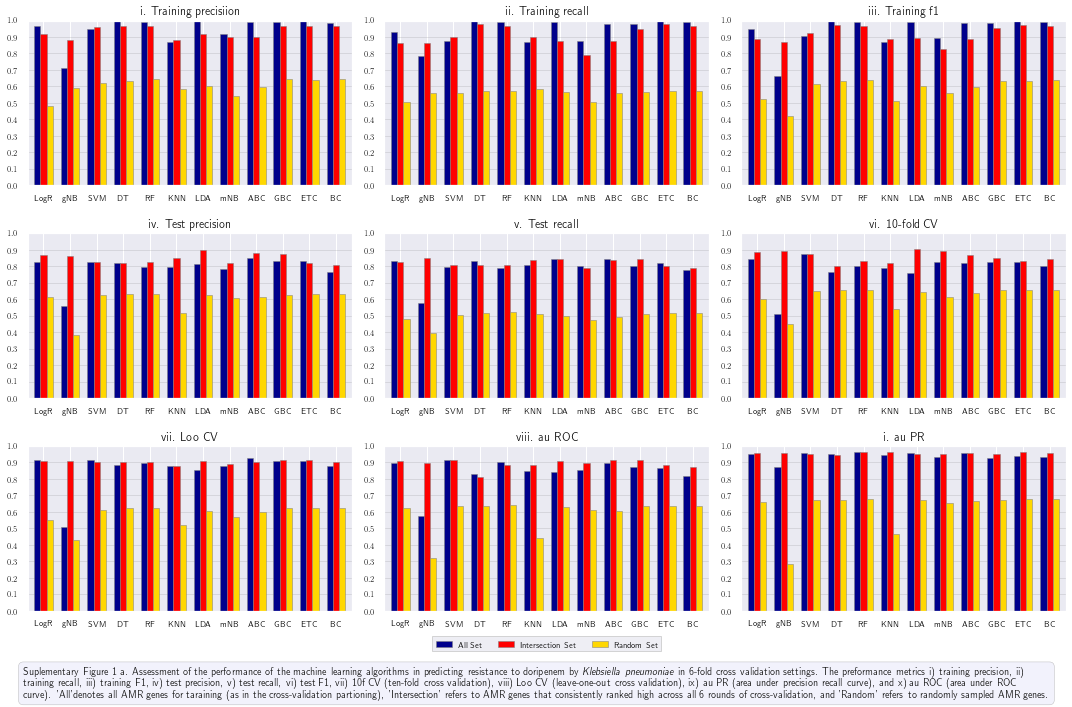

All Set Results ertapenem KN


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,0.995,0.995,0.995,0.777,0.783,0.765,0.765,0.895,0.909,0.906
1,gNB,0.955,0.948,0.948,0.687,0.694,0.669,0.688,0.765,0.815,0.807
2,SVM,0.981,0.980,0.980,0.759,0.789,0.765,0.758,0.897,0.916,0.878
3,DT,1.000,1.000,1.000,0.755,0.749,0.732,0.720,0.749,0.826,0.862
4,RF,0.999,0.999,0.999,0.730,0.756,0.731,0.694,0.805,0.812,0.851
5,KNN,0.905,0.902,0.902,0.776,0.772,0.747,0.687,0.844,0.855,0.856
6,LDA,1.000,1.000,1.000,0.702,0.682,0.672,0.698,0.647,0.730,0.779
7,mNB,0.908,0.905,0.905,0.782,0.788,0.769,0.730,0.845,0.859,0.845
8,ABC,1.000,1.000,1.000,0.836,0.821,0.808,0.821,0.883,0.876,0.912
9,GBC,1.000,1.000,1.000,0.832,0.827,0.815,0.787,0.849,0.863,0.934


Intersection Set Results ertapenem KN


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,0.908,0.906,0.905,0.787,0.811,0.784,0.774,0.919,0.940,0.867
1,gNB,0.899,0.893,0.893,0.772,0.806,0.782,0.834,0.845,0.873,0.873
2,SVM,0.935,0.931,0.930,0.783,0.811,0.786,0.772,0.892,0.914,0.878
3,DT,0.979,0.978,0.978,0.752,0.767,0.747,0.752,0.766,0.853,0.873
4,RF,0.978,0.977,0.977,0.734,0.756,0.731,0.756,0.847,0.887,0.862
5,KNN,0.899,0.898,0.898,0.759,0.778,0.751,0.731,0.831,0.885,0.856
6,LDA,0.922,0.918,0.918,0.840,0.832,0.820,0.797,0.915,0.936,0.906
7,mNB,0.780,0.766,0.763,0.709,0.699,0.668,0.272,0.606,0.709,0.735
8,ABC,0.900,0.898,0.897,0.824,0.810,0.796,0.794,0.911,0.930,0.867
9,GBC,0.979,0.978,0.978,0.803,0.799,0.788,0.794,0.856,0.884,0.845


Random Set Results ertapenem KN


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,Loo_CV_Avg,au_ROC_avg,au_PR_avg
0,LogR,0.721,0.734,0.701,0.676,0.648,0.659,0.674,0.681,0.670,0.663
1,gNB,0.707,0.629,0.650,0.616,0.567,0.564,0.625,0.626,0.581,0.583
2,SVM,0.732,0.753,0.711,0.691,0.662,0.666,0.684,0.691,0.691,0.670
3,DT,0.729,0.752,0.712,0.680,0.654,0.655,0.676,0.688,0.672,0.668
4,RF,0.729,0.753,0.712,0.680,0.653,0.655,0.677,0.688,0.675,0.669
5,KNN,0.703,0.672,0.669,0.627,0.591,0.580,0.636,0.642,0.602,0.616
6,LDA,0.723,0.751,0.706,0.678,0.649,0.658,0.674,0.683,0.671,0.666
7,mNB,0.716,0.717,0.688,0.665,0.634,0.655,0.660,0.668,0.653,0.642
8,ABC,0.722,0.744,0.704,0.680,0.651,0.661,0.675,0.683,0.675,0.665
9,GBC,0.731,0.753,0.712,0.681,0.657,0.656,0.679,0.689,0.675,0.668


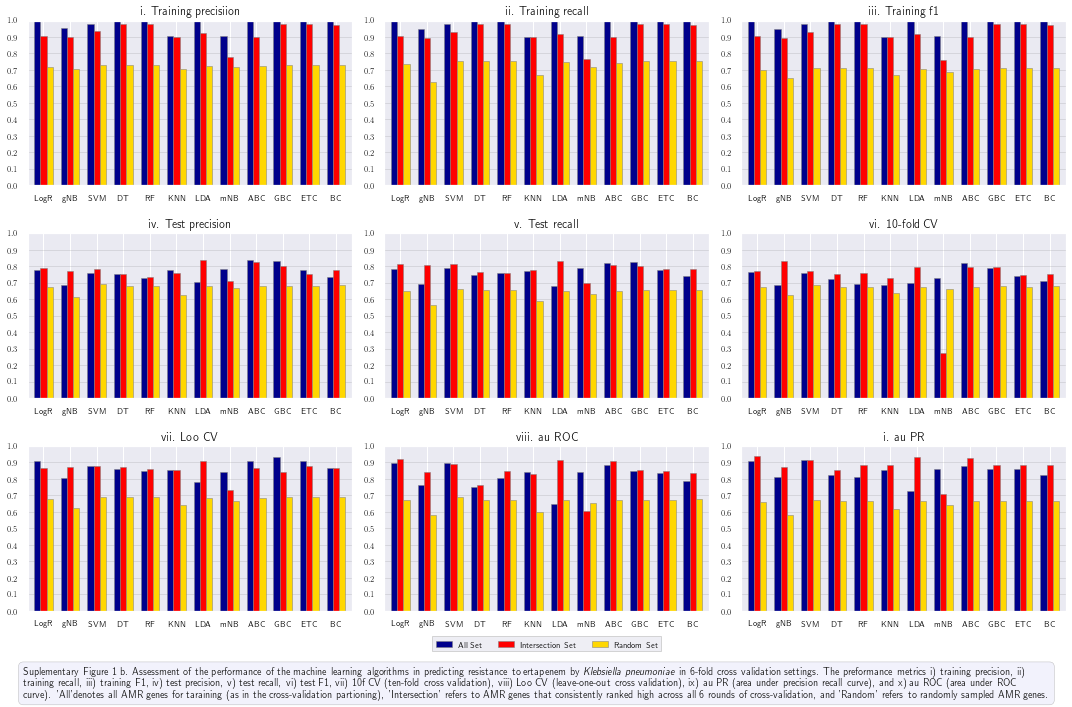

All Set Results imipenem KN


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,0.996,0.994,0.995,0.869,0.825,0.800,0.794,0.927,0.943,0.910
1,gNB,0.978,0.982,0.980,0.786,0.826,0.797,0.815,0.837,0.915,0.895
2,SVM,0.966,0.951,0.957,0.813,0.845,0.820,0.835,0.947,0.960,0.900
3,DT,0.997,0.995,0.996,0.843,0.805,0.789,0.749,0.805,0.896,0.835
4,RF,0.995,0.993,0.994,0.868,0.832,0.815,0.761,0.921,0.937,0.900
5,KNN,0.919,0.921,0.920,0.831,0.821,0.806,0.773,0.875,0.913,0.845
6,LDA,0.997,0.995,0.996,0.831,0.829,0.824,0.780,0.834,0.898,0.815
7,mNB,0.915,0.899,0.904,0.874,0.833,0.818,0.776,0.892,0.919,0.850
8,ABC,0.997,0.995,0.996,0.882,0.847,0.830,0.824,0.897,0.930,0.885
9,GBC,0.997,0.995,0.996,0.868,0.820,0.794,0.793,0.915,0.935,0.900


Intersection Set Results imipenem KN


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,0.909,0.896,0.901,0.856,0.812,0.792,0.793,0.921,0.944,0.860
1,gNB,0.851,0.851,0.838,0.795,0.787,0.776,0.752,0.884,0.914,0.825
2,SVM,0.946,0.920,0.927,0.836,0.848,0.821,0.812,0.933,0.943,0.915
3,DT,0.962,0.967,0.963,0.841,0.795,0.768,0.768,0.820,0.893,0.840
4,RF,0.962,0.966,0.963,0.872,0.837,0.820,0.785,0.907,0.934,0.840
5,KNN,0.894,0.896,0.895,0.875,0.843,0.829,0.795,0.910,0.932,0.880
6,LDA,0.921,0.906,0.911,0.899,0.861,0.845,0.810,0.925,0.942,0.890
7,mNB,0.744,0.726,0.728,0.710,0.660,0.607,0.608,0.815,0.842,0.720
8,ABC,0.900,0.893,0.895,0.821,0.802,0.782,0.782,0.889,0.903,0.860
9,GBC,0.962,0.954,0.957,0.867,0.826,0.808,0.796,0.897,0.911,0.860


Random Set Results imipenem KN


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,Loo_CV_Avg,au_ROC_avg,au_PR_avg
0,LogR,0.681,0.746,0.658,0.642,0.620,0.649,0.658,0.652,0.651,0.644
1,gNB,0.685,0.609,0.603,0.573,0.525,0.531,0.592,0.585,0.554,0.526
2,SVM,0.708,0.748,0.684,0.654,0.633,0.652,0.670,0.670,0.667,0.657
3,DT,0.709,0.749,0.690,0.644,0.628,0.641,0.664,0.669,0.655,0.655
4,RF,0.708,0.748,0.687,0.652,0.633,0.650,0.666,0.670,0.658,0.655
5,KNN,0.633,0.673,0.609,0.573,0.570,0.611,0.611,0.603,0.589,0.595
6,LDA,0.702,0.744,0.679,0.641,0.624,0.642,0.661,0.663,0.652,0.648
7,mNB,0.587,0.503,0.556,0.549,0.491,0.516,0.561,0.548,0.489,0.545
8,ABC,0.705,0.748,0.681,0.649,0.628,0.652,0.664,0.665,0.650,0.650
9,GBC,0.707,0.748,0.687,0.656,0.631,0.653,0.667,0.669,0.667,0.656


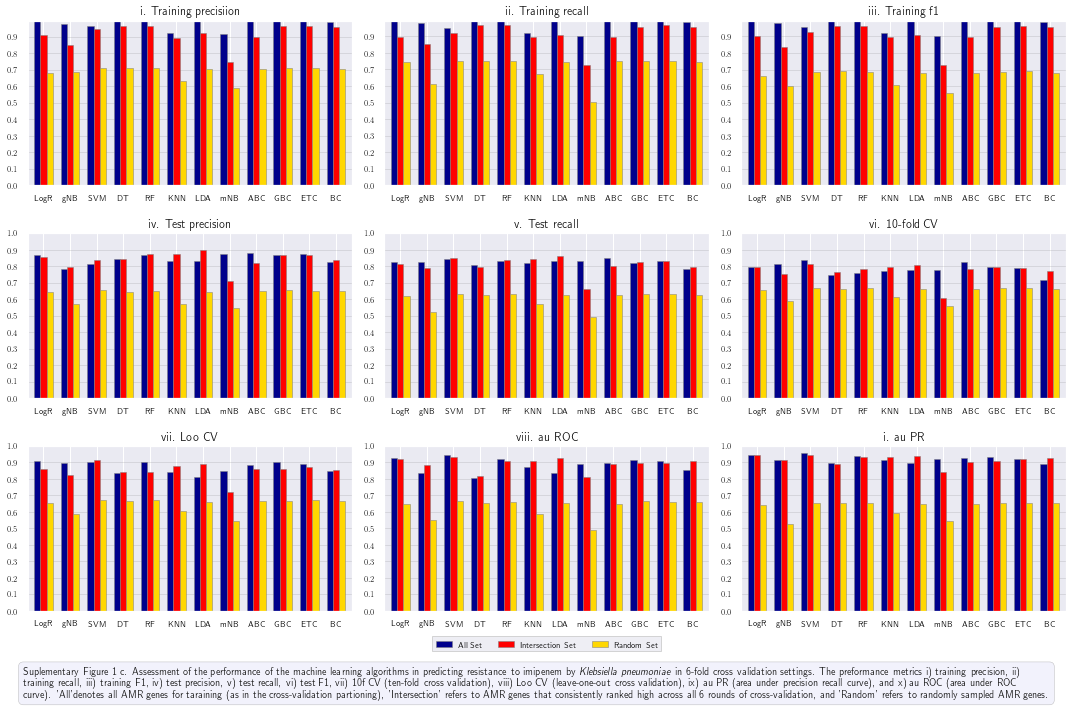

All Set Results meropenem KN


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,0.986,0.986,0.987,0.810,0.750,0.731,0.760,0.911,0.900,0.895
1,gNB,0.916,0.887,0.888,0.725,0.692,0.684,0.745,0.790,0.795,0.786
2,SVM,0.961,0.962,0.962,0.855,0.761,0.724,0.745,0.961,0.965,0.929
3,DT,1.000,1.000,1.000,0.748,0.705,0.692,0.748,0.705,0.794,0.924
4,RF,0.989,0.989,0.989,0.788,0.683,0.654,0.720,0.850,0.835,0.891
5,KNN,0.917,0.901,0.906,0.793,0.690,0.664,0.717,0.795,0.818,0.840
6,LDA,0.996,0.997,0.997,0.754,0.726,0.720,0.694,0.756,0.803,0.853
7,mNB,0.896,0.899,0.895,0.810,0.730,0.697,0.771,0.871,0.888,0.866
8,ABC,0.999,0.999,0.999,0.831,0.792,0.775,0.786,0.847,0.836,0.933
9,GBC,0.996,0.997,0.997,0.814,0.781,0.774,0.804,0.888,0.906,0.916


Intersection Set Results meropenem KN


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,0.906,0.906,0.906,0.842,0.791,0.775,0.781,0.931,0.918,0.857
1,gNB,0.864,0.868,0.864,0.852,0.796,0.776,0.832,0.939,0.943,0.853
2,SVM,0.946,0.944,0.945,0.832,0.763,0.735,0.774,0.887,0.863,0.878
3,DT,0.972,0.970,0.971,0.777,0.738,0.733,0.745,0.743,0.805,0.874
4,RF,0.969,0.968,0.968,0.820,0.763,0.748,0.757,0.876,0.874,0.895
5,KNN,0.914,0.908,0.910,0.768,0.697,0.682,0.741,0.804,0.824,0.849
6,LDA,0.922,0.918,0.919,0.850,0.814,0.801,0.807,0.928,0.904,0.887
7,mNB,0.840,0.843,0.836,0.823,0.734,0.692,0.760,0.946,0.926,0.807
8,ABC,0.921,0.921,0.921,0.832,0.796,0.778,0.776,0.936,0.920,0.882
9,GBC,0.966,0.964,0.965,0.794,0.750,0.737,0.779,0.906,0.881,0.887


Random Set Results meropenem KN


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,Loo_CV_Avg,au_ROC_avg,au_PR_avg
0,LogR,0.715,0.776,0.698,0.659,0.625,0.655,0.672,0.675,0.642,0.668
1,gNB,0.678,0.556,0.612,0.574,0.516,0.550,0.601,0.591,0.552,0.555
2,SVM,0.718,0.803,0.705,0.674,0.634,0.671,0.675,0.681,0.656,0.675
3,DT,0.721,0.802,0.708,0.661,0.626,0.653,0.670,0.679,0.643,0.672
4,RF,0.715,0.801,0.705,0.665,0.629,0.661,0.669,0.677,0.647,0.672
5,KNN,0.686,0.664,0.649,0.630,0.572,0.605,0.634,0.630,0.566,0.612
6,LDA,0.716,0.782,0.700,0.656,0.623,0.653,0.670,0.675,0.641,0.668
7,mNB,0.717,0.770,0.693,0.650,0.620,0.655,0.671,0.671,0.634,0.660
8,ABC,0.712,0.785,0.698,0.659,0.624,0.653,0.669,0.674,0.638,0.669
9,GBC,0.722,0.803,0.708,0.662,0.630,0.655,0.673,0.681,0.648,0.673


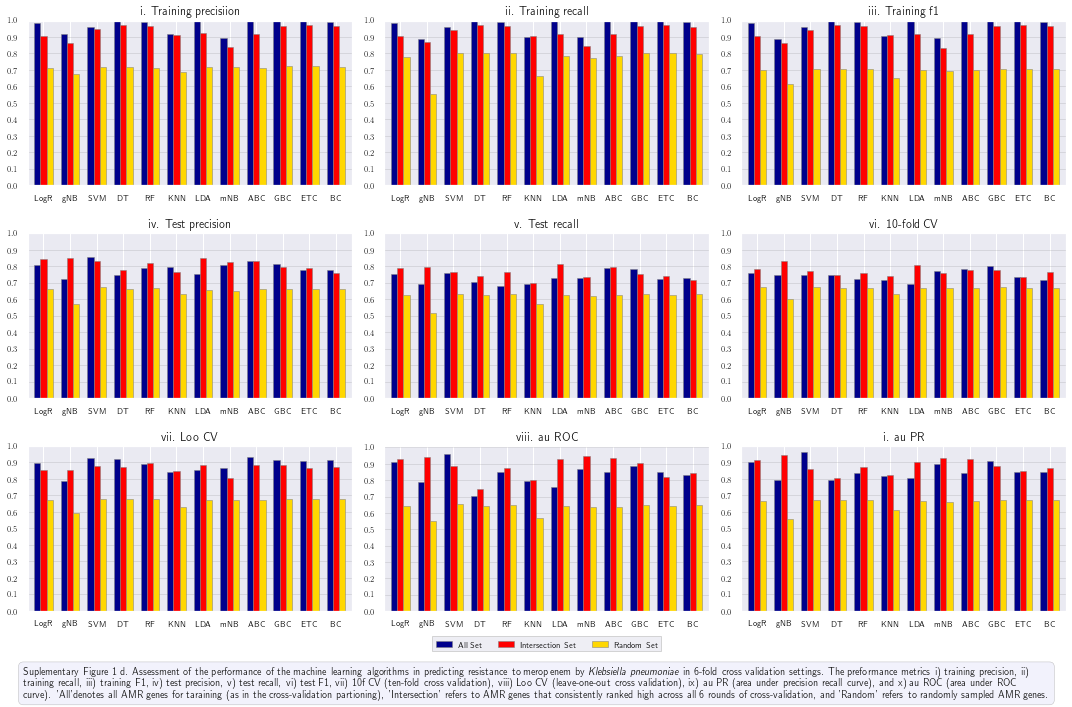

In [2]:
#All set, Intersection set and Random set performance for Klebsiella pneumoniae

#Dictionary of antibiotics
antb_SN = {'doripenem': '1 a', 'ertapenem': '1 b', 'imipenem': '1 c', 'meropenem': '1 d'}

for antb, SN in antb_SN.items():
    
    #Acronym for Klebsiella pneumoniae
    bacteria = 'KN'
    
    #Italicized full name bacteria for fig output
    italic_name = r"\textit{Klebsiella pneumoniae}"
    
    #Figure plot number
    supplementary_fig_no = SN
    
    #Import amr-ast data from github repository
    file_name = f'https://github.com/Janaksunuwar/AMR_prediction/raw/main/Data/amr_ast_{antb}_{bacteria}.csv'

    #Import bacterial strains without carbapenemase from github repository
    To_predict = 'https://github.com/Janaksunuwar/AMR_prediction/raw/main/Data/carbapenem_to_predict_KN.csv'
    
    #no of validation
    validation_no = 6
    
    ML_run()

All Set Results doripenem EcS


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,0.946,0.940,0.939,0.896,0.833,0.820,0.809,0.890,0.911,0.837
1,gNB,0.962,0.960,0.959,0.876,0.854,0.854,0.842,0.854,0.896,0.898
2,SVM,0.946,0.940,0.939,0.906,0.854,0.842,0.816,0.917,0.928,0.857
3,DT,1.000,1.000,1.000,0.865,0.812,0.802,0.772,0.812,0.886,0.816
4,RF,1.000,1.000,1.000,0.821,0.775,0.761,0.737,0.836,0.869,0.816
5,KNN,0.848,0.788,0.774,0.769,0.775,0.739,0.668,0.793,0.886,0.714
6,LDA,0.992,0.992,0.992,0.806,0.833,0.803,0.731,0.938,0.948,0.918
7,mNB,0.923,0.919,0.918,0.885,0.812,0.797,0.759,0.900,0.916,0.816
8,ABC,1.000,1.000,1.000,0.914,0.896,0.893,0.798,0.921,0.950,0.857
9,GBC,1.000,1.000,1.000,0.872,0.838,0.831,0.771,0.912,0.940,0.898


Intersection Set Results doripenem EcS


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,0.933,0.931,0.931,0.924,0.875,0.864,0.846,0.921,0.942,0.857
1,gNB,0.948,0.944,0.943,0.932,0.896,0.893,0.896,0.917,0.942,0.918
2,SVM,0.944,0.943,0.943,0.924,0.875,0.864,0.854,0.952,0.967,0.878
3,DT,1.000,1.000,1.000,0.865,0.833,0.830,0.777,0.833,0.893,0.816
4,RF,1.000,1.000,1.000,0.896,0.833,0.820,0.797,0.888,0.926,0.837
5,KNN,0.832,0.803,0.796,0.838,0.775,0.759,0.732,0.902,0.942,0.755
6,LDA,0.962,0.960,0.959,0.942,0.917,0.915,0.910,0.917,0.946,0.939
7,mNB,0.855,0.850,0.849,0.867,0.838,0.827,0.762,0.923,0.933,0.816
8,ABC,1.000,1.000,1.000,0.882,0.833,0.823,0.794,0.911,0.936,0.878
9,GBC,1.000,1.000,1.000,0.915,0.875,0.872,0.815,0.900,0.934,0.878


Random Set Results doripenem EcS


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,Loo_CV_Avg,au_ROC_avg,au_PR_avg
0,LogR,0.761,0.694,0.749,0.755,0.725,0.700,0.730,0.737,0.726,0.721
1,gNB,0.756,0.665,0.713,0.689,0.644,0.593,0.687,0.691,0.652,0.656
2,SVM,0.771,0.760,0.757,0.756,0.732,0.693,0.736,0.744,0.735,0.725
3,DT,0.772,0.760,0.755,0.757,0.729,0.692,0.727,0.739,0.729,0.713
4,RF,0.771,0.760,0.757,0.754,0.725,0.672,0.729,0.740,0.727,0.719
5,KNN,0.734,0.656,0.703,0.694,0.657,0.606,0.676,0.684,0.653,0.652
6,LDA,0.772,0.760,0.759,0.757,0.731,0.699,0.738,0.745,0.731,0.728
7,mNB,0.645,0.589,0.614,0.542,0.556,0.387,0.601,0.599,0.470,0.581
8,ABC,0.772,0.760,0.759,0.758,0.731,0.703,0.737,0.745,0.732,0.727
9,GBC,0.774,0.760,0.757,0.759,0.733,0.698,0.736,0.745,0.733,0.723


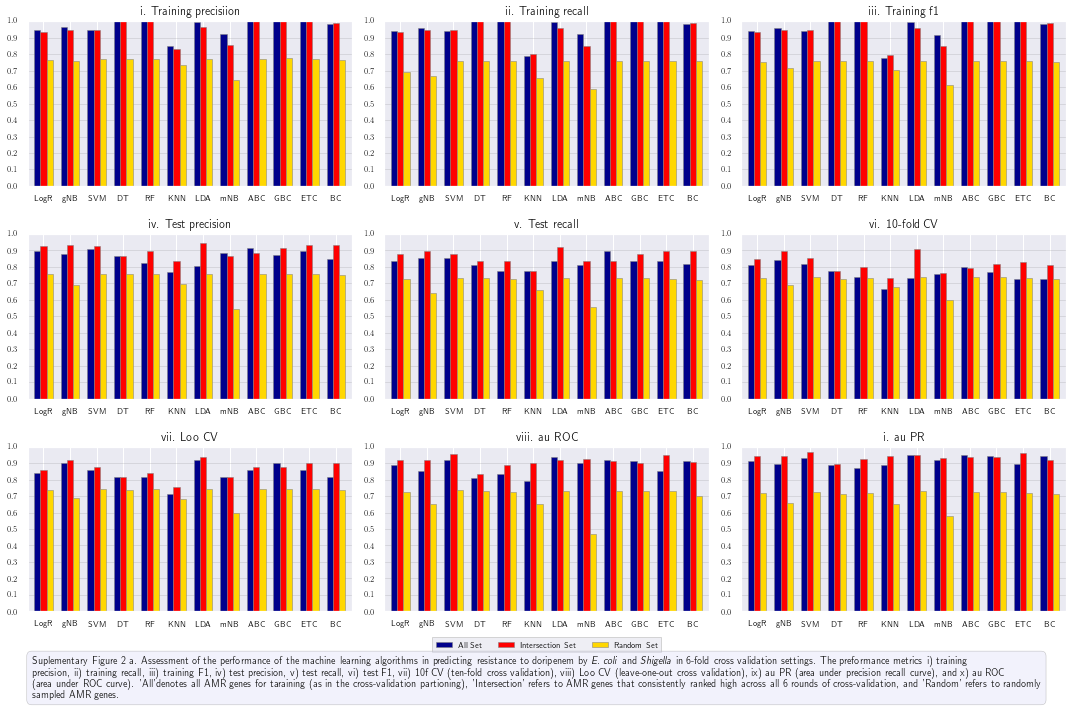

All Set Results ertapenem EcS


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,0.970,0.964,0.966,0.886,0.870,0.860,0.858,0.940,0.931,0.930
1,gNB,0.982,0.979,0.980,0.870,0.855,0.850,0.871,0.838,0.877,0.922
2,SVM,0.960,0.951,0.953,0.926,0.918,0.917,0.895,0.940,0.920,0.938
3,DT,0.994,0.993,0.994,0.819,0.780,0.771,0.795,0.780,0.838,0.891
4,RF,0.987,0.985,0.986,0.839,0.804,0.801,0.797,0.930,0.939,0.907
5,KNN,0.880,0.831,0.833,0.775,0.752,0.715,0.728,0.829,0.848,0.798
6,LDA,0.991,0.990,0.991,0.688,0.676,0.665,0.657,0.662,0.719,0.798
7,mNB,0.943,0.938,0.939,0.881,0.873,0.872,0.863,0.905,0.898,0.922
8,ABC,0.994,0.993,0.994,0.835,0.813,0.804,0.786,0.876,0.896,0.922
9,GBC,0.994,0.993,0.994,0.838,0.796,0.786,0.786,0.908,0.920,0.907


Intersection Set Results ertapenem EcS


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,0.938,0.931,0.933,0.879,0.861,0.859,0.864,0.915,0.934,0.899
1,gNB,0.944,0.928,0.930,0.891,0.869,0.863,0.875,0.886,0.911,0.915
2,SVM,0.952,0.949,0.950,0.878,0.869,0.860,0.872,0.939,0.938,0.930
3,DT,0.962,0.958,0.959,0.843,0.821,0.812,0.815,0.794,0.845,0.915
4,RF,0.961,0.952,0.954,0.827,0.814,0.805,0.823,0.916,0.920,0.891
5,KNN,0.929,0.919,0.922,0.848,0.825,0.820,0.822,0.913,0.925,0.884
6,LDA,0.934,0.915,0.918,0.867,0.808,0.789,0.794,0.912,0.931,0.891
7,mNB,0.920,0.894,0.897,0.864,0.836,0.836,0.431,0.788,0.851,0.884
8,ABC,0.950,0.945,0.947,0.866,0.852,0.844,0.848,0.908,0.924,0.899
9,GBC,0.962,0.958,0.959,0.822,0.805,0.797,0.826,0.900,0.917,0.907


Random Set Results ertapenem EcS


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,Loo_CV_Avg,au_ROC_avg,au_PR_avg
0,LogR,0.791,0.760,0.774,0.751,0.724,0.715,0.746,0.754,0.714,0.738
1,gNB,0.787,0.593,0.760,0.744,0.693,0.705,0.730,0.736,0.698,0.714
2,SVM,0.790,0.768,0.778,0.756,0.728,0.712,0.748,0.757,0.715,0.743
3,DT,0.790,0.768,0.778,0.754,0.723,0.715,0.743,0.754,0.713,0.740
4,RF,0.784,0.760,0.776,0.756,0.718,0.701,0.739,0.751,0.713,0.740
5,KNN,0.782,0.676,0.763,0.744,0.702,0.702,0.733,0.740,0.696,0.724
6,LDA,0.792,0.763,0.777,0.757,0.725,0.712,0.746,0.755,0.715,0.740
7,mNB,0.790,0.751,0.768,0.750,0.717,0.714,0.743,0.749,0.714,0.730
8,ABC,0.786,0.755,0.776,0.748,0.718,0.704,0.740,0.751,0.706,0.738
9,GBC,0.789,0.768,0.778,0.754,0.722,0.712,0.742,0.754,0.712,0.740


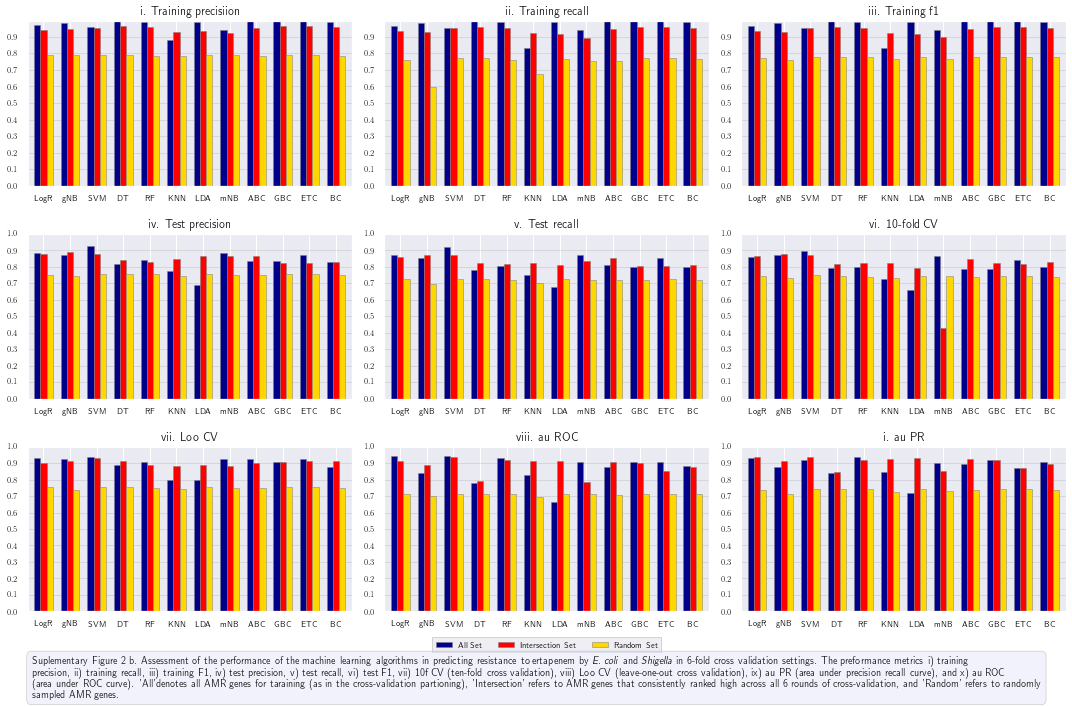

All Set Results imipenem EcS


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,0.962,0.970,0.965,0.930,0.916,0.899,0.890,0.954,0.974,0.953
1,gNB,1.000,1.000,1.000,0.940,0.888,0.885,0.821,0.888,0.940,0.922
2,SVM,0.950,0.960,0.953,0.927,0.913,0.901,0.888,0.953,0.975,0.922
3,DT,1.000,1.000,1.000,0.919,0.904,0.884,0.891,0.904,0.957,0.922
4,RF,0.996,0.997,0.997,0.876,0.860,0.830,0.834,0.933,0.958,0.922
5,KNN,0.838,0.825,0.796,0.738,0.758,0.689,0.667,0.860,0.936,0.812
6,LDA,0.997,0.996,0.997,0.679,0.714,0.689,0.657,0.764,0.825,0.750
7,mNB,0.944,0.950,0.946,0.922,0.923,0.918,0.795,0.929,0.966,0.922
8,ABC,1.000,1.000,1.000,0.958,0.944,0.930,0.903,0.941,0.965,0.969
9,GBC,1.000,1.000,1.000,0.944,0.931,0.915,0.874,0.948,0.973,0.938


Intersection Set Results imipenem EcS


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,0.966,0.973,0.968,0.942,0.933,0.915,0.897,0.986,0.991,0.953
1,gNB,1.000,1.000,1.000,0.967,0.950,0.952,0.955,0.950,0.967,0.984
2,SVM,1.000,1.000,1.000,0.972,0.972,0.967,0.967,1.000,1.000,0.969
3,DT,1.000,1.000,1.000,0.930,0.916,0.899,0.878,0.916,0.962,0.938
4,RF,0.990,0.992,0.990,0.911,0.902,0.884,0.880,0.967,0.984,0.938
5,KNN,0.890,0.897,0.881,0.889,0.879,0.852,0.813,0.933,0.974,0.859
6,LDA,0.993,0.995,0.994,0.928,0.931,0.920,0.940,1.000,1.000,0.969
7,mNB,0.656,0.614,0.607,0.488,0.530,0.479,0.526,0.766,0.871,0.562
8,ABC,1.000,1.000,1.000,0.958,0.944,0.930,0.900,0.958,0.983,0.969
9,GBC,1.000,1.000,1.000,0.958,0.944,0.930,0.893,0.958,0.983,0.969


Random Set Results imipenem EcS


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,Loo_CV_Avg,au_ROC_avg,au_PR_avg
0,LogR,0.718,0.755,0.711,0.648,0.691,0.588,0.710,0.707,0.681,0.708
1,gNB,0.790,0.681,0.755,0.769,0.732,0.699,0.744,0.746,0.716,0.712
2,SVM,0.776,0.781,0.758,0.768,0.743,0.704,0.747,0.751,0.732,0.730
3,DT,0.779,0.781,0.761,0.767,0.739,0.700,0.738,0.748,0.727,0.722
4,RF,0.776,0.781,0.757,0.767,0.738,0.702,0.736,0.745,0.729,0.719
5,KNN,0.772,0.690,0.730,0.756,0.707,0.680,0.715,0.720,0.706,0.676
6,LDA,0.775,0.781,0.753,0.768,0.741,0.706,0.743,0.747,0.732,0.723
7,mNB,0.609,0.614,0.594,0.639,0.572,0.555,0.617,0.600,0.622,0.609
8,ABC,0.774,0.781,0.754,0.766,0.740,0.699,0.739,0.746,0.730,0.721
9,GBC,0.771,0.781,0.755,0.765,0.736,0.700,0.735,0.744,0.727,0.721


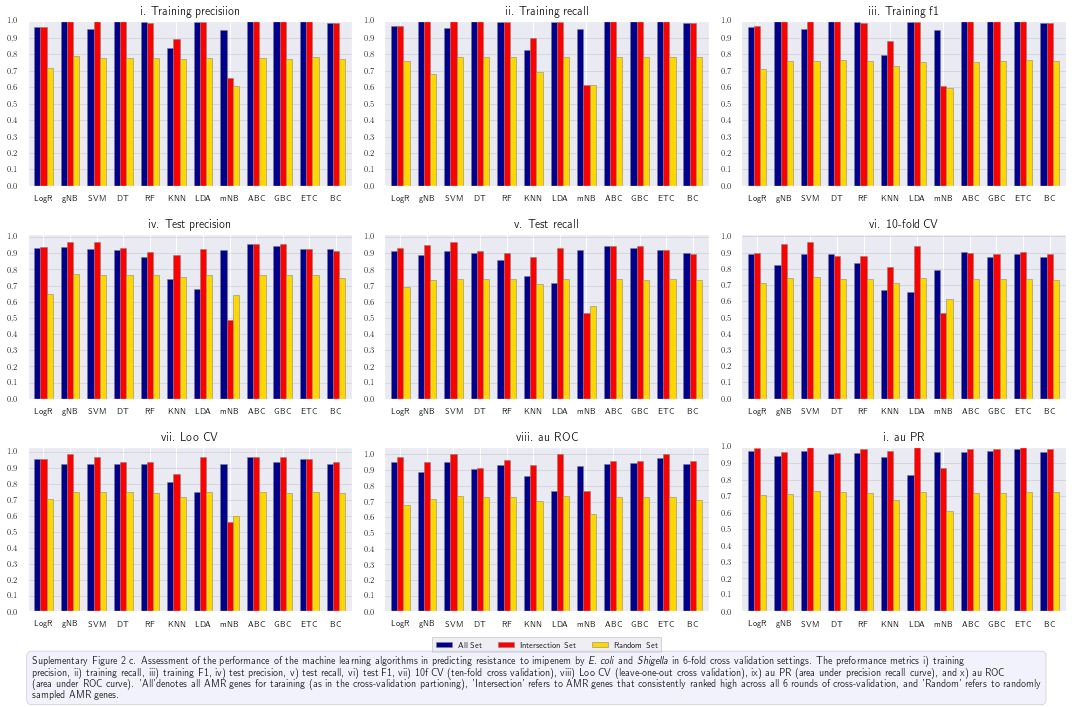

All Set Results meropenem EcS


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,0.979,0.978,0.978,0.928,0.921,0.921,0.886,0.970,0.962,0.945
1,gNB,0.989,0.989,0.989,0.957,0.955,0.955,0.950,0.955,0.966,0.956
2,SVM,0.963,0.962,0.962,0.937,0.934,0.933,0.938,0.964,0.963,0.945
3,DT,0.989,0.989,0.989,0.900,0.892,0.889,0.884,0.892,0.929,0.890
4,RF,0.989,0.989,0.989,0.911,0.903,0.897,0.871,0.967,0.969,0.945
5,KNN,0.947,0.940,0.940,0.917,0.870,0.849,0.847,0.936,0.949,0.901
6,LDA,0.987,0.986,0.987,0.816,0.786,0.778,0.844,0.756,0.826,0.802
7,mNB,0.960,0.960,0.960,0.945,0.945,0.944,0.907,0.961,0.962,0.945
8,ABC,0.989,0.989,0.989,0.922,0.909,0.908,0.873,0.957,0.944,0.967
9,GBC,0.989,0.989,0.989,0.908,0.902,0.900,0.858,0.941,0.958,0.912


Intersection Set Results meropenem EcS


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,0.967,0.967,0.967,0.936,0.933,0.933,0.901,0.973,0.964,0.956
1,gNB,0.967,0.964,0.964,0.968,0.966,0.966,0.939,0.973,0.979,0.956
2,SVM,0.974,0.974,0.974,0.937,0.934,0.933,0.901,0.988,0.991,0.956
3,DT,0.989,0.989,0.989,0.917,0.914,0.911,0.913,0.914,0.940,0.934
4,RF,0.989,0.989,0.989,0.945,0.945,0.944,0.928,0.963,0.969,0.945
5,KNN,0.958,0.958,0.958,0.945,0.945,0.944,0.935,0.970,0.982,0.956
6,LDA,0.968,0.967,0.967,0.901,0.890,0.888,0.842,0.949,0.943,0.934
7,mNB,0.958,0.958,0.958,0.936,0.933,0.933,0.885,0.955,0.959,0.967
8,ABC,0.989,0.989,0.989,0.946,0.944,0.944,0.875,0.957,0.944,0.956
9,GBC,0.989,0.989,0.989,0.937,0.933,0.934,0.894,0.934,0.959,0.934


Random Set Results meropenem EcS


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,Loo_CV_Avg,au_ROC_avg,au_PR_avg
0,LogR,0.832,0.816,0.825,0.791,0.789,0.768,0.800,0.808,0.765,0.798
1,gNB,0.808,0.700,0.780,0.773,0.737,0.732,0.761,0.765,0.729,0.740
2,SVM,0.841,0.845,0.832,0.801,0.804,0.780,0.817,0.821,0.779,0.813
3,DT,0.839,0.847,0.832,0.802,0.797,0.773,0.807,0.816,0.774,0.805
4,RF,0.838,0.847,0.832,0.802,0.797,0.768,0.807,0.816,0.773,0.806
5,KNN,0.837,0.843,0.827,0.801,0.797,0.781,0.807,0.814,0.775,0.801
6,LDA,0.833,0.823,0.825,0.796,0.793,0.768,0.803,0.810,0.765,0.799
7,mNB,0.833,0.803,0.810,0.795,0.784,0.768,0.786,0.796,0.761,0.767
8,ABC,0.837,0.823,0.828,0.800,0.795,0.775,0.806,0.814,0.771,0.803
9,GBC,0.839,0.848,0.832,0.803,0.798,0.773,0.809,0.817,0.775,0.808


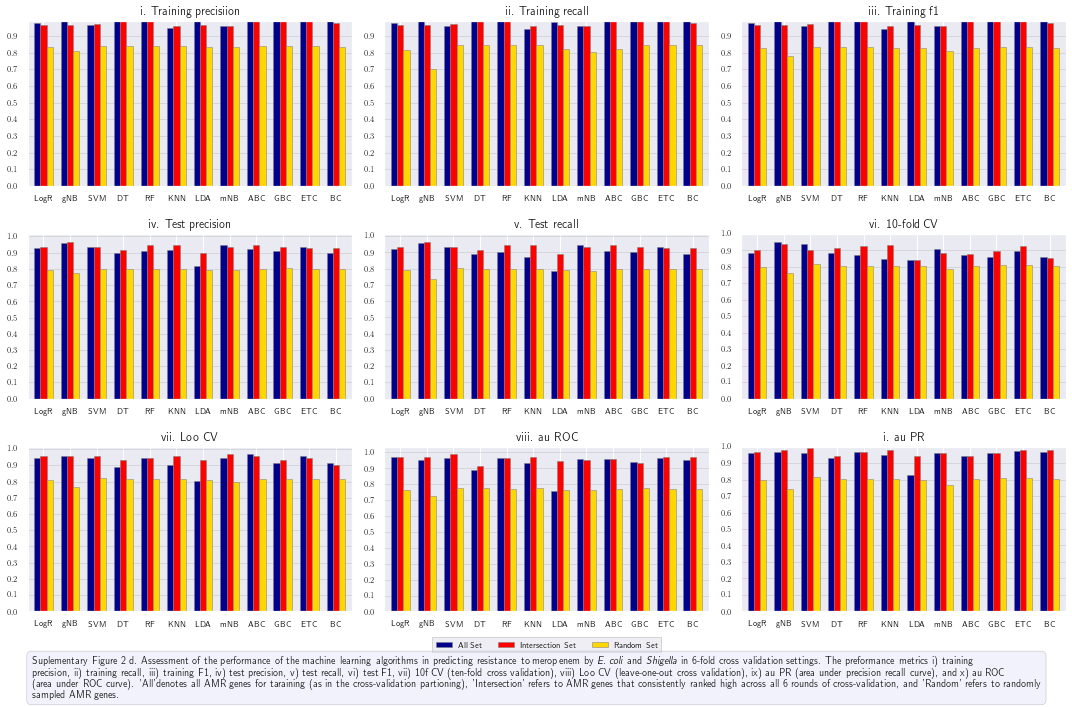

In [3]:
#All set, Intersection set and Random set performance for E. coli and Shigella

#Dictionary of antibiotics
antb_SN = {'doripenem': '2 a', 'ertapenem': '2 b', 'imipenem': '2 c', 'meropenem': '2 d'}

for antb, SN in antb_SN.items():
    
    #Acronym for E. coli and Shigella
    bacteria = 'EcS'
    
    #Italicized full name bacteria for fig output
    it1 = r"\textit{E. coli}"
    it2 = r"\textit{Shigella}"
    italic_name = it1 + ' and ' + it2
    
    #Figure plot name
    supplementary_fig_no = SN
    
    #Import amr-ast data from github repository
    file_name = f'https://github.com/Janaksunuwar/AMR_prediction/raw/main/Data/amr_ast_{antb}_{bacteria}.csv'

    #Import bacterial strains without carbapenemase from github repository
    To_predict = 'https://github.com/Janaksunuwar/AMR_prediction/raw/main/Data/carbapenem_to_predict_EcS.csv'
    
    #no of validation
    validation_no = 6
    
    ML_run()

All Set Results doripenem PA


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,1.000,1.000,1.000,0.923,0.896,0.880,0.868,1.000,1.000,0.886
1,gNB,1.000,1.000,1.000,0.942,0.938,0.931,0.892,0.930,0.955,0.932
2,SVM,0.996,0.995,0.995,0.930,0.917,0.908,0.901,1.000,1.000,0.909
3,DT,1.000,1.000,1.000,0.983,0.972,0.974,0.940,0.972,0.984,0.977
4,RF,0.996,0.995,0.995,0.951,0.938,0.932,0.914,1.000,1.000,0.886
5,KNN,0.873,0.827,0.821,0.693,0.750,0.681,0.725,0.875,0.927,0.773
6,LDA,0.938,0.936,0.936,0.786,0.750,0.727,0.836,0.872,0.860,0.841
7,mNB,0.991,0.991,0.991,0.923,0.896,0.880,0.856,0.944,0.957,0.886
8,ABC,1.000,1.000,1.000,0.928,0.875,0.871,0.896,0.979,0.986,0.932
9,GBC,1.000,1.000,1.000,0.956,0.930,0.930,0.906,0.958,0.976,0.977


Intersection Set Results doripenem PA


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,1.000,1.000,1.000,0.964,0.938,0.927,0.925,1.000,1.000,0.955
1,gNB,0.963,0.959,0.959,0.972,0.958,0.956,0.925,1.000,1.000,0.932
2,SVM,1.000,1.000,1.000,0.972,0.958,0.956,0.949,1.000,1.000,0.955
3,DT,1.000,1.000,1.000,0.983,0.972,0.974,0.945,0.972,0.984,0.977
4,RF,0.996,0.995,0.995,0.964,0.938,0.927,0.944,1.000,1.000,0.932
5,KNN,0.908,0.886,0.885,0.923,0.896,0.880,0.865,0.938,0.970,0.886
6,LDA,0.996,0.995,0.995,0.899,0.833,0.819,0.898,0.986,0.984,0.909
7,mNB,0.870,0.868,0.868,0.885,0.854,0.835,0.786,0.927,0.955,0.841
8,ABC,1.000,1.000,1.000,0.956,0.930,0.930,0.953,0.979,0.986,0.977
9,GBC,1.000,1.000,1.000,0.956,0.930,0.930,0.953,0.938,0.965,0.977


Random Set Results doripenem PA


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,Loo_CV_Avg,au_ROC_avg,au_PR_avg
0,LogR,0.790,0.759,0.792,0.760,0.731,0.697,0.730,0.756,0.699,0.738
1,gNB,0.791,0.568,0.760,0.768,0.700,0.680,0.722,0.734,0.720,0.700
2,SVM,0.813,0.778,0.807,0.799,0.764,0.756,0.762,0.781,0.760,0.761
3,DT,0.805,0.778,0.805,0.787,0.751,0.726,0.747,0.772,0.734,0.753
4,RF,0.796,0.773,0.800,0.787,0.747,0.715,0.738,0.765,0.732,0.747
5,KNN,0.755,0.732,0.726,0.711,0.683,0.691,0.704,0.710,0.675,0.682
6,LDA,0.797,0.778,0.797,0.786,0.749,0.720,0.743,0.766,0.728,0.748
7,mNB,0.756,0.763,0.748,0.624,0.686,0.550,0.689,0.713,0.576,0.688
8,ABC,0.795,0.778,0.798,0.784,0.747,0.713,0.740,0.765,0.730,0.748
9,GBC,0.807,0.778,0.806,0.787,0.751,0.724,0.747,0.772,0.728,0.752


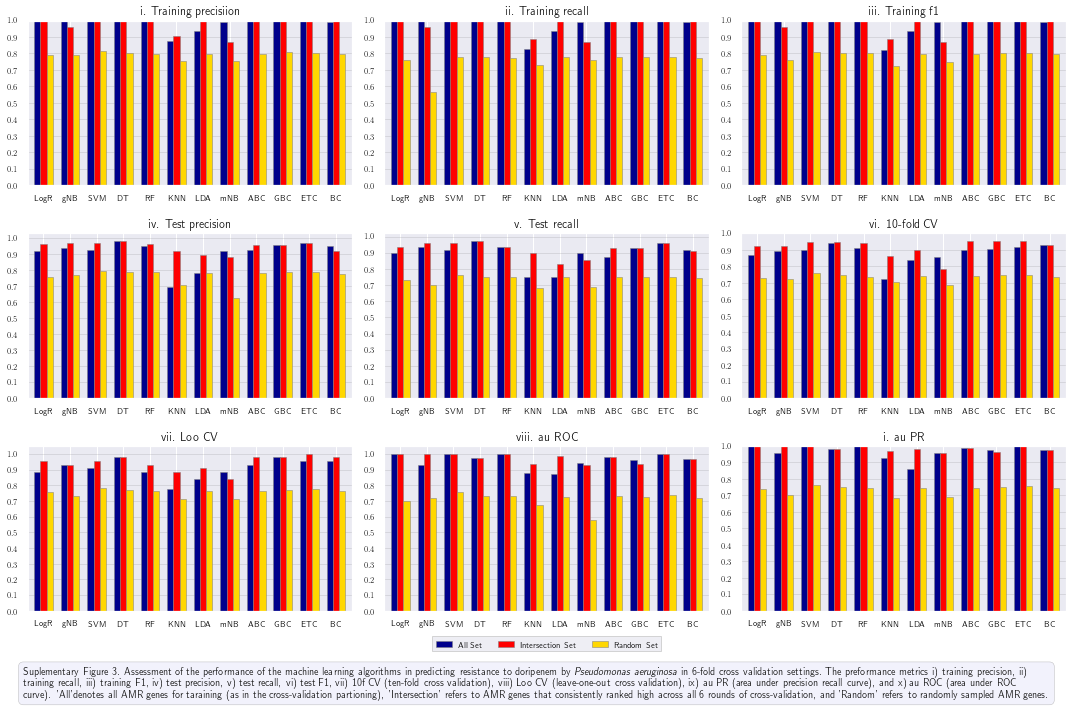

In [4]:
#All set, Intersection set and Random set performance for Pseudomonas aeruginosa

#Dictionary of antibiotics
antb_SN = {'doripenem': '3'}

for antb, SN in antb_SN.items():
    
    #Acronym for Pseudomonas aeruginosa
    bacteria = 'PA'
    
    #Italicized full name bacteria for fig output
    italic_name = r"\textit{Pseudomonas aeruginosa}"

    #Figure plot number
    supplementary_fig_no = SN
    
    #Import amr-ast data from github repository
    file_name = f'https://github.com/Janaksunuwar/AMR_prediction/raw/main/Data/amr_ast_{antb}_{bacteria}.csv'

    #Import bacterial strains without carbapenemase from github repository
    To_predict = 'https://github.com/Janaksunuwar/AMR_prediction/raw/main/Data/carbapenem_to_predict_PA.csv'
    
    #no of validation
    validation_no = 6
    
    ML_run()

All Set Results kanamycin SE


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,0.963,0.961,0.961,0.752,0.756,0.742,0.725,0.871,0.896,0.952
1,gNB,0.895,0.863,0.855,0.802,0.772,0.753,0.749,0.848,0.854,0.936
2,SVM,0.969,0.968,0.969,0.802,0.805,0.792,0.721,0.916,0.919,0.963
3,DT,0.988,0.988,0.988,0.800,0.788,0.781,0.636,0.773,0.832,0.964
4,RF,0.986,0.986,0.986,0.785,0.785,0.769,0.657,0.769,0.771,0.966
5,KNN,0.956,0.955,0.955,0.769,0.755,0.736,0.697,0.788,0.836,0.932
6,LDA,0.956,0.954,0.954,0.887,0.882,0.881,0.780,0.921,0.923,0.939
7,mNB,0.913,0.911,0.910,0.849,0.828,0.809,0.730,0.876,0.869,0.903
8,ABC,0.964,0.963,0.963,0.785,0.786,0.775,0.694,0.829,0.806,0.945
9,GBC,0.977,0.976,0.976,0.790,0.788,0.771,0.711,0.926,0.941,0.964


Intersection Set Results kanamycin SE


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,0.952,0.950,0.950,0.760,0.758,0.748,0.738,0.880,0.897,0.946
1,gNB,0.954,0.950,0.951,0.923,0.917,0.916,0.871,0.913,0.938,0.951
2,SVM,0.967,0.966,0.966,0.822,0.826,0.813,0.752,0.913,0.940,0.960
3,DT,0.973,0.973,0.973,0.864,0.861,0.860,0.733,0.851,0.884,0.958
4,RF,0.971,0.970,0.970,0.836,0.831,0.827,0.746,0.882,0.880,0.960
5,KNN,0.949,0.947,0.947,0.849,0.829,0.826,0.733,0.850,0.898,0.934
6,LDA,0.955,0.952,0.952,0.914,0.906,0.905,0.848,0.925,0.948,0.951
7,mNB,0.904,0.900,0.899,0.855,0.833,0.814,0.775,0.924,0.935,0.880
8,ABC,0.954,0.951,0.951,0.848,0.840,0.835,0.743,0.849,0.839,0.948
9,GBC,0.969,0.968,0.968,0.853,0.847,0.843,0.713,0.916,0.913,0.963


Random Set Results kanamycin SE


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,Loo_CV_Avg,au_ROC_avg,au_PR_avg
0,LogR,0.671,0.570,0.669,0.691,0.628,0.603,0.648,0.653,0.633,0.652
1,gNB,0.676,0.506,0.595,0.546,0.508,0.486,0.595,0.581,0.537,0.534
2,SVM,0.672,0.571,0.675,0.690,0.617,0.593,0.643,0.652,0.624,0.655
3,DT,0.673,0.571,0.675,0.690,0.617,0.594,0.643,0.652,0.625,0.655
4,RF,0.670,0.571,0.674,0.692,0.620,0.597,0.643,0.652,0.627,0.655
5,KNN,0.644,0.511,0.585,0.529,0.524,0.500,0.596,0.580,0.531,0.552
6,LDA,0.671,0.571,0.670,0.690,0.623,0.598,0.646,0.652,0.630,0.653
7,mNB,0.679,0.570,0.647,0.657,0.593,0.573,0.636,0.634,0.604,0.615
8,ABC,0.669,0.570,0.669,0.690,0.621,0.598,0.644,0.650,0.628,0.651
9,GBC,0.672,0.571,0.675,0.690,0.617,0.594,0.643,0.652,0.625,0.655


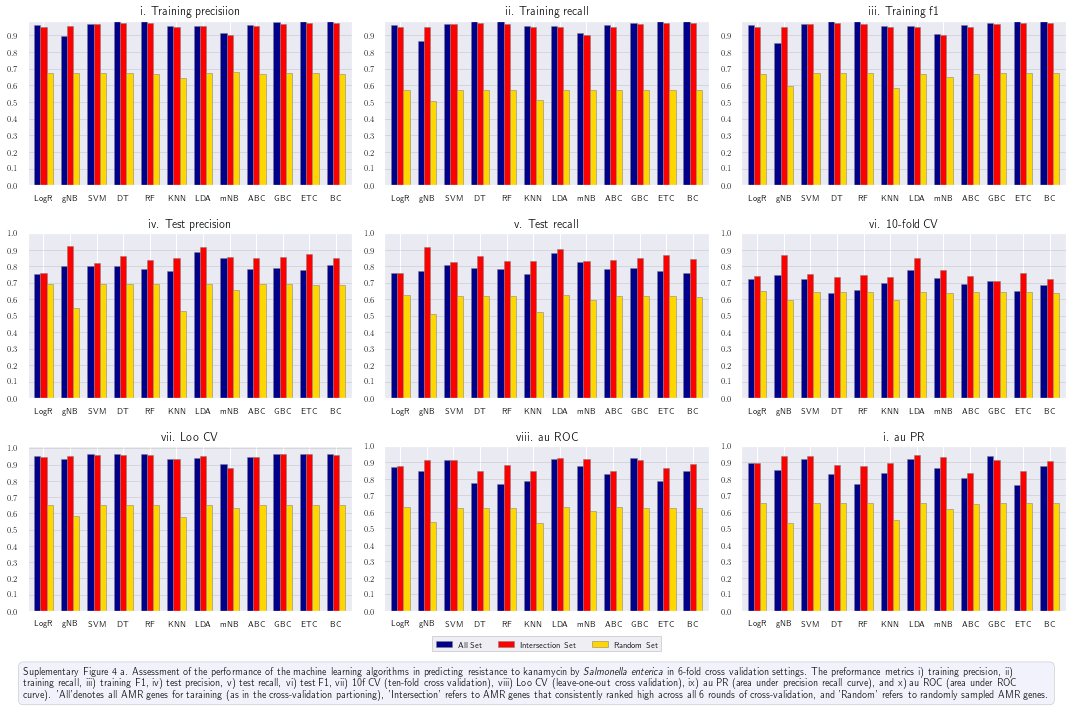

All Set Results streptomycin SE


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,0.936,0.931,0.932,0.854,0.765,0.738,0.731,0.856,0.722,0.928
1,gNB,0.901,0.867,0.869,0.852,0.760,0.732,0.753,0.760,0.869,0.859
2,SVM,0.953,0.948,0.949,0.865,0.782,0.759,0.735,0.885,0.781,0.942
3,DT,0.963,0.959,0.960,0.845,0.748,0.710,0.732,0.679,0.638,0.936
4,RF,0.962,0.958,0.959,0.852,0.757,0.724,0.734,0.763,0.710,0.940
5,KNN,0.763,0.678,0.633,0.501,0.563,0.473,0.454,0.582,0.594,0.621
6,LDA,0.944,0.936,0.938,0.804,0.709,0.674,0.680,0.688,0.552,0.918
7,mNB,0.882,0.877,0.878,0.897,0.845,0.833,0.844,0.959,0.856,0.867
8,ABC,0.951,0.946,0.947,0.856,0.776,0.754,0.721,0.816,0.644,0.933
9,GBC,0.952,0.947,0.948,0.856,0.776,0.755,0.736,0.812,0.662,0.934


Intersection Set Results streptomycin SE


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,0.923,0.917,0.918,0.892,0.830,0.813,0.767,0.906,0.749,0.919
1,gNB,0.890,0.849,0.849,0.888,0.816,0.797,0.771,0.818,0.897,0.847
2,SVM,0.937,0.932,0.932,0.894,0.826,0.807,0.776,0.876,0.718,0.925
3,DT,0.944,0.939,0.940,0.887,0.811,0.785,0.750,0.742,0.627,0.921
4,RF,0.945,0.938,0.939,0.886,0.812,0.790,0.746,0.749,0.662,0.923
5,KNN,0.765,0.667,0.615,0.528,0.576,0.483,0.484,0.584,0.569,0.610
6,LDA,0.916,0.907,0.908,0.885,0.829,0.814,0.770,0.885,0.677,0.888
7,mNB,0.861,0.856,0.857,0.878,0.831,0.820,0.814,0.953,0.945,0.858
8,ABC,0.921,0.914,0.915,0.886,0.819,0.801,0.763,0.843,0.726,0.894
9,GBC,0.939,0.934,0.935,0.890,0.825,0.808,0.775,0.812,0.715,0.920


Random Set Results streptomycin SE


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,Loo_CV_Avg,au_ROC_avg,au_PR_avg
0,LogR,0.717,0.638,0.687,0.698,0.644,0.675,0.680,0.677,0.640,0.658
1,gNB,0.703,0.511,0.620,0.596,0.519,0.544,0.616,0.601,0.545,0.555
2,SVM,0.718,0.638,0.687,0.702,0.646,0.681,0.682,0.678,0.643,0.660
3,DT,0.716,0.638,0.687,0.699,0.644,0.676,0.680,0.677,0.640,0.659
4,RF,0.717,0.638,0.687,0.698,0.644,0.675,0.680,0.677,0.640,0.659
5,KNN,0.477,0.498,0.453,0.464,0.465,0.432,0.512,0.479,0.462,0.491
6,LDA,0.717,0.638,0.687,0.698,0.644,0.675,0.680,0.677,0.640,0.659
7,mNB,0.711,0.631,0.652,0.647,0.577,0.593,0.646,0.637,0.604,0.603
8,ABC,0.717,0.638,0.687,0.698,0.644,0.675,0.680,0.677,0.640,0.659
9,GBC,0.718,0.638,0.687,0.699,0.645,0.677,0.681,0.678,0.641,0.659


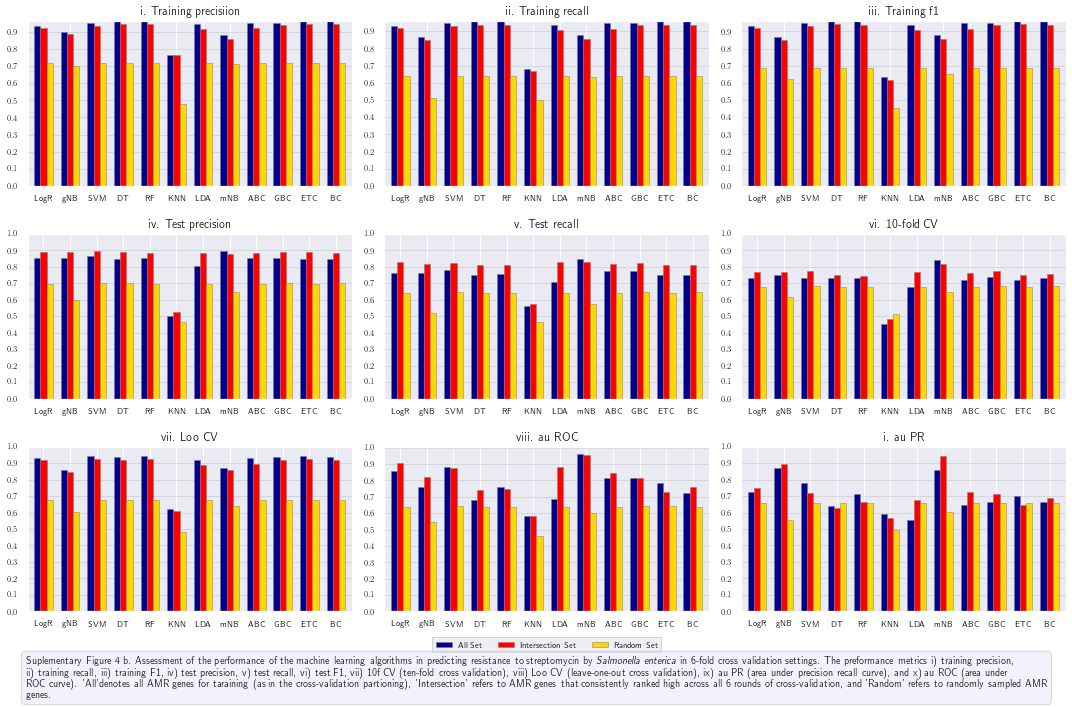

In [6]:
#All set, Intersection set and Random set performance for Salmonella enterica

#Dictionary of antibiotics
antb_SN = {'kanamycin': '4 a', 'streptomycin': '4 b'}

for antb, SN in antb_SN.items():
    
    #Acronym for Salmonella enterica
    bacteria = 'SE'
    
    #Italicized full name bacteria for fig output
    italic_name = r"\textit{Salmonella enterica}"

    #Figure plot number
    supplementary_fig_no = SN
    
    #Import amr-ast data from github repository
    file_name = f'https://github.com/Janaksunuwar/AMR_prediction/raw/main/Data/amr_ast_{antb}_{bacteria}.csv'

    #Import bacterial strains without carbapenemase from github repository
    To_predict = 'https://github.com/Janaksunuwar/AMR_prediction/raw/main/Data/aminoglycoside_to_predict_SE.csv'
    
    #no of validation
    validation_no = 6
    
    ML_run()

All Set Results clindamycin CJ


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,1.000,1.000,1.000,0.979,0.958,0.960,0.875,1.000,1.000,1.000
1,gNB,1.000,1.000,1.000,0.972,0.972,0.967,0.986,0.972,0.972,1.000
2,SVM,1.000,1.000,1.000,1.000,1.000,1.000,0.983,1.000,1.000,0.962
3,DT,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
4,RF,1.000,1.000,1.000,0.951,0.930,0.927,0.978,1.000,1.000,1.000
5,KNN,0.967,0.917,0.928,0.779,0.833,0.801,0.733,1.000,1.000,0.846
6,LDA,0.920,0.902,0.908,0.647,0.722,0.672,0.759,0.708,0.701,0.846
7,mNB,1.000,1.000,1.000,0.979,0.958,0.960,0.811,1.000,1.000,0.962
8,ABC,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
9,GBC,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


Intersection Set Results clindamycin CJ


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,1.000,1.000,1.000,0.979,0.958,0.960,0.892,1.000,1.000,1.000
1,gNB,1.000,1.000,1.000,0.972,0.972,0.967,0.978,0.972,0.972,0.962
2,SVM,1.000,1.000,1.000,0.979,0.958,0.960,0.967,1.000,1.000,0.962
3,DT,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
4,RF,1.000,1.000,1.000,0.979,0.958,0.960,0.958,1.000,1.000,1.000
5,KNN,0.957,0.941,0.946,0.883,0.917,0.896,0.786,1.000,1.000,0.885
6,LDA,0.912,0.909,0.909,0.751,0.806,0.767,0.767,0.819,0.805,0.846
7,mNB,1.000,1.000,1.000,1.000,1.000,1.000,0.928,1.000,1.000,1.000
8,ABC,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
9,GBC,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


Random Set Results clindamycin CJ


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,Loo_CV_Avg,au_ROC_avg,au_PR_avg
0,LogR,0.796,0.688,0.785,0.675,0.689,0.696,0.753,0.756,0.723,0.760
1,gNB,0.800,0.730,0.768,0.659,0.703,0.637,0.730,0.741,0.726,0.708
2,SVM,0.816,0.700,0.809,0.670,0.707,0.706,0.751,0.768,0.710,0.760
3,DT,0.822,0.700,0.813,0.678,0.716,0.717,0.766,0.777,0.727,0.773
4,RF,0.814,0.726,0.808,0.682,0.717,0.717,0.760,0.773,0.733,0.769
5,KNN,0.585,0.500,0.610,0.635,0.598,0.644,0.660,0.629,0.669,0.693
6,LDA,0.767,0.700,0.755,0.636,0.637,0.612,0.692,0.709,0.650,0.700
7,mNB,0.814,0.688,0.799,0.687,0.707,0.703,0.762,0.769,0.727,0.765
8,ABC,0.817,0.707,0.807,0.692,0.719,0.720,0.762,0.774,0.745,0.767
9,GBC,0.822,0.700,0.812,0.678,0.716,0.717,0.765,0.776,0.727,0.771


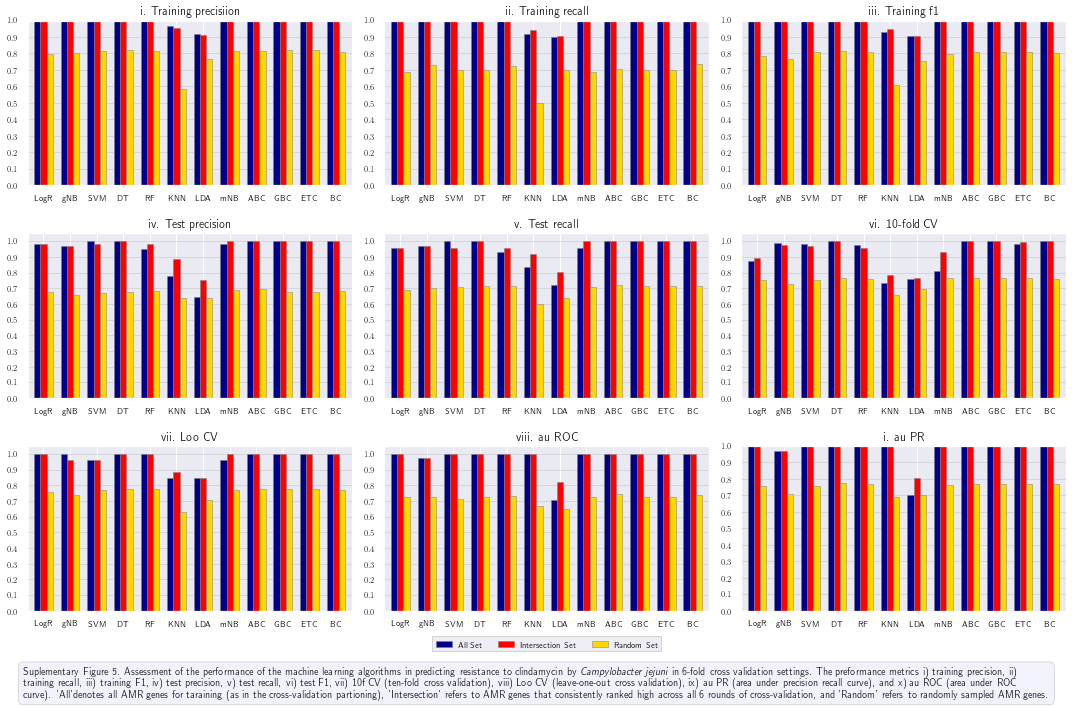

In [8]:
#All set, Intersection set and Random set performance for Campylobacter jejuni

#Dictionary of antibiotics
antb_SN = {'clindamycin': '5'}

for antb, SN in antb_SN.items():
    
    #Acronym for Campylobacter jejuni
    bacteria = 'CJ'
    
    #Italicized full name bacteria for fig output
    italic_name = r"\textit{Campylobacter jejuni}"

    #Figure plot number
    supplementary_fig_no = SN
    
    #Import amr-ast data from github repository
    file_name = f'https://github.com/Janaksunuwar/AMR_prediction/raw/main/Data/amr_ast_{antb}_{bacteria}.csv'

    #Import bacterial strains without carbapenemase from github repository
    To_predict = 'https://github.com/Janaksunuwar/AMR_prediction/raw/main/Data/clindamycin_to_predict_CJ.csv'
    
    #no of validation
    validation_no = 6
    
    ML_run()

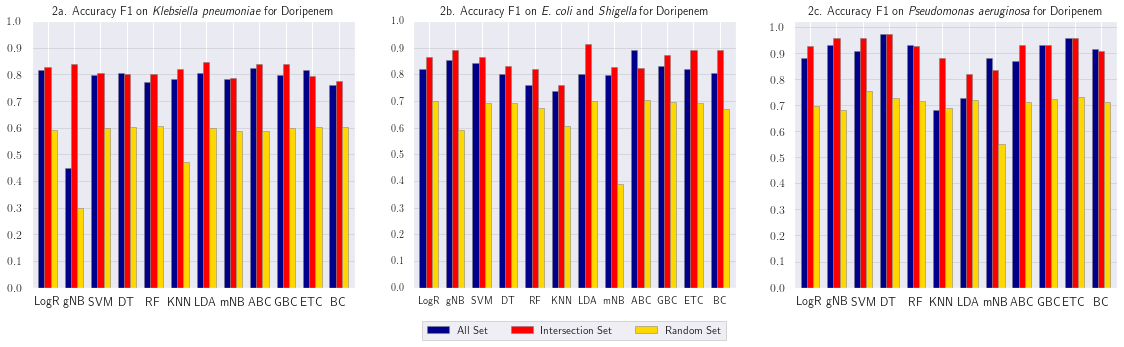

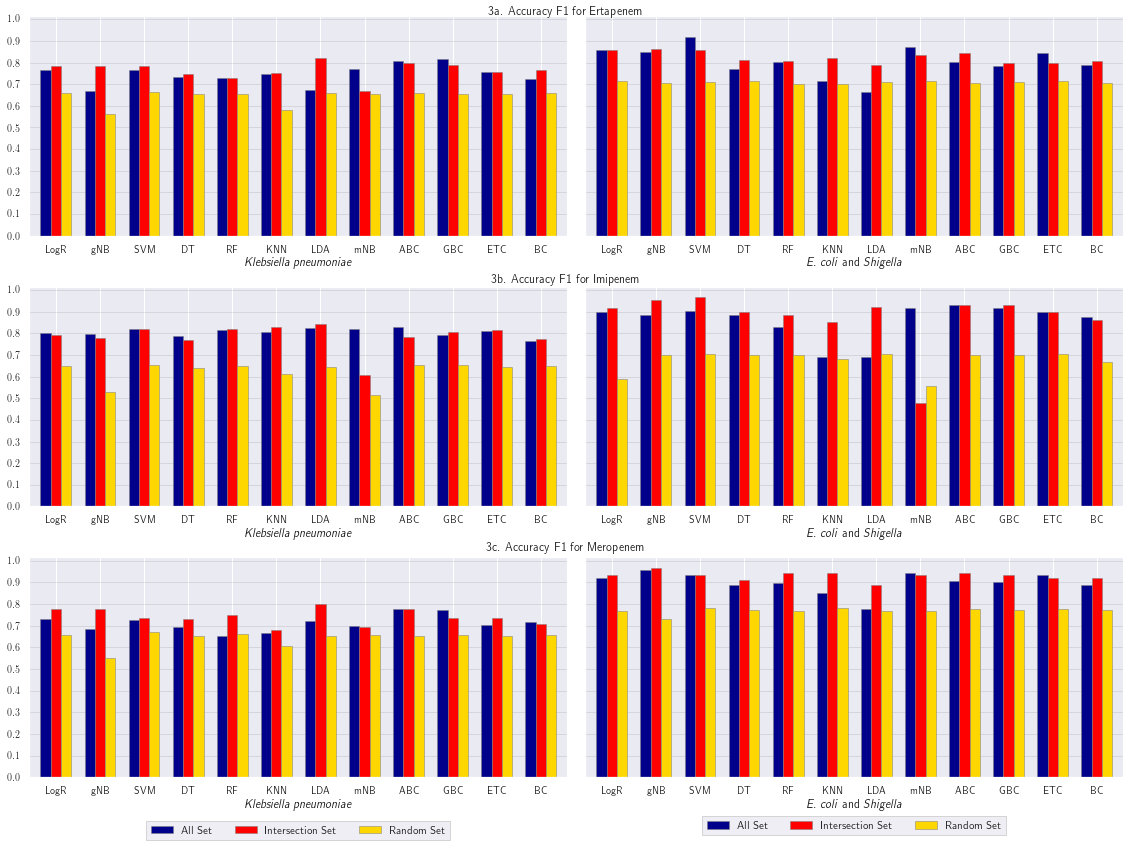

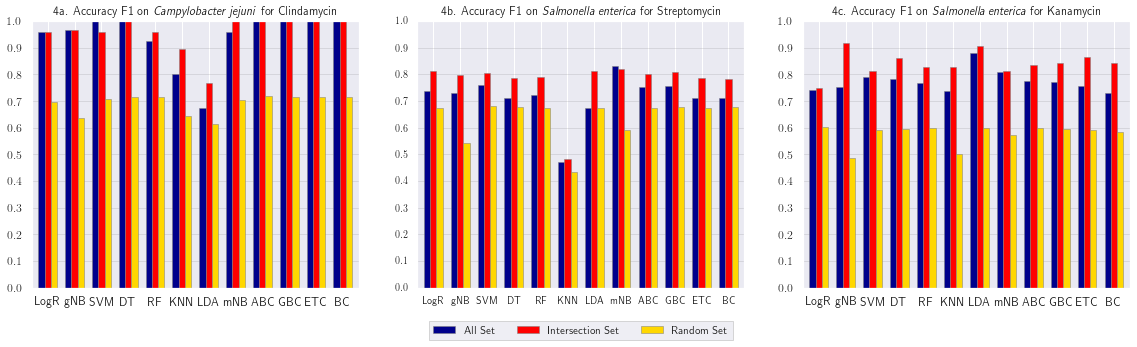

In [18]:
#Plot Figure 2, Figure 3 and Figure 4

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rc

#Activate latex text rendering
rc('text', usetex=True)

#Italic bacterial names for figures
it1 = r"\textit{Klebsiella pneumoniae}"
it2 = r"\textit{E. coli}"
it2_ = r"\textit{Shigella}"
it3 = r"\textit{Pseudomonas aeruginosa}"
it4 = r"\textit{Campylobacter jejuni}"
it5 = r"\textit{Salmonella enterica}"

# vlidation number
val_no = 6

#Open files for figure 2
d1 = pd.read_csv(f'KN_doripenem_F1_comparision_{val_no}-fold_CV.csv')
d1.set_index(['classifier'], inplace=True)
d2 = pd.read_csv(f'EcS_doripenem_F1_comparision_{val_no}-fold_CV.csv')
d2.set_index(['classifier'], inplace=True)
d3 = pd.read_csv(f'PA_doripenem_F1_comparision_{val_no}-fold_CV.csv')
d3.set_index(['classifier'], inplace=True)

#Bar colors and set name
my_colors= ['darkblue', 'red', 'gold']
my_labels = ['All Set', 'Intersection Set', 'Random Set']

#Subplots for figure 2
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(16,5))
plt.xlabel("")

ax1 = d1.plot(kind='bar', ax=axes[0], color=my_colors, width = 0.7, edgecolor='grey', 
         linewidth=0.5, title =f"2a. Accuracy F1 on {it1} for Doripenem", 
         legend=False, yticks = np.arange(0,1.1, step=0.1),
         fontsize=12, rot=0)
ax1.set_xlabel('')
ax1.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
ax1.set_axisbelow(True)

ax2= d2.plot(kind='bar', ax=axes[1], color=my_colors, width = 0.7, edgecolor='grey', 
         linewidth=0.5, title =f"2b. Accuracy F1 on {it2} and {it2_} for Doripenem", 
         legend=False, yticks = np.arange(0,1.1, step=0.1),
         fontsize=10, rot=0)
ax2.set_xlabel('')
ax2.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
ax2.set_axisbelow(True)
ax2.legend(labels=my_labels, loc='lower center', borderaxespad=0.1, ncol=3,
           bbox_to_anchor=(0.5, -0.2),
           fancybox=False, shadow=False, prop={'size': 11})
ax2.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
ax2.set_axisbelow(True)

ax3= d3.plot(kind='bar', ax=axes[2], color=my_colors, width = 0.7, edgecolor='grey', 
         linewidth=0.5, title =f"2c. Accuracy F1 on {it3} for Doripenem", 
         legend=False, yticks = np.arange(0,1.1, step=0.1),
         fontsize=12, rot=0)
ax3.set_xlabel('')
ax3.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
ax3.set_axisbelow(True)

fig.tight_layout()
plt.show()

fig.savefig(f'ML_Plot_F1_Fig2_{val_no}-fold_CV.tiff', dpi=300, format="tiff", pil_kwargs={"compression": "tiff_lzw"})

#Open files for figure 3
d4 = pd.read_csv(f'KN_ertapenem_F1_comparision_{val_no}-fold_CV.csv')
d4.set_index(['classifier'], inplace=True)
d5 = pd.read_csv(f'EcS_ertapenem_F1_comparision_{val_no}-fold_CV.csv')
d5.set_index(['classifier'], inplace=True)
d6 = pd.read_csv(f'KN_imipenem_F1_comparision_{val_no}-fold_CV.csv')
d6.set_index(['classifier'], inplace=True)
d7 = pd.read_csv(f'EcS_imipenem_F1_comparision_{val_no}-fold_CV.csv')
d7.set_index(['classifier'], inplace=True)
d8 = pd.read_csv(f'KN_meropenem_F1_comparision_{val_no}-fold_CV.csv')
d8.set_index(['classifier'], inplace=True)
d9 = pd.read_csv(f'EcS_meropenem_F1_comparision_{val_no}-fold_CV.csv')
d9.set_index(['classifier'], inplace=True)

#Subplots for figure 3
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=False, sharey=True, figsize=(16,12))
plt.xlabel("")

ax4 = d4.plot(kind='bar', ax=axes[0,0], color=my_colors, width = 0.7, edgecolor='grey', 
         linewidth=0.5, 
         legend=False, yticks = np.arange(0,1.1, step=0.1),
         fontsize=10, rot=0)
ax4.set_xlabel(f'{it1}')
ax4.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
ax4.set_axisbelow(True)

ax5= d5.plot(kind='bar', ax=axes[0,1], color=my_colors, width = 0.7, edgecolor='grey', 
         linewidth=0.5, 
         legend=False, yticks = np.arange(0,1.1, step=0.1),
         fontsize=10, rot=0)
ax5.set_xlabel(f'{it2} and {it2_}')
ax5.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
ax5.set_axisbelow(True)

ax6= d6.plot(kind='bar', ax=axes[1,0], color=my_colors, width = 0.7, edgecolor='grey', 
         linewidth=0.5, 
         legend=False, yticks = np.arange(0,1.1, step=0.1),
         fontsize=10, rot=0)
ax6.set_xlabel(f'{it1}')
ax6.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
ax6.set_axisbelow(True)

ax7= d7.plot(kind='bar', ax=axes[1,1], color=my_colors, width = 0.7, edgecolor='grey', 
         linewidth=0.5, 
         legend=False, yticks = np.arange(0,1.1, step=0.1),
         fontsize=10, rot=0)
ax7.set_xlabel(f'{it2} and {it2_}')
ax7.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
ax7.set_axisbelow(True)

ax8= d8.plot(kind='bar', ax=axes[2,0], color=my_colors, width = 0.7, edgecolor='grey', 
         linewidth=0.5, 
         legend=False, yticks = np.arange(0,1.1, step=0.1),
         fontsize=10, rot=0, label=my_labels)

ax8.legend(labels=my_labels, loc='lower center', borderaxespad=0.1, ncol=3,
           bbox_to_anchor=(0.5, -0.29),
           fancybox=False, shadow=False, prop={'size': 11})
ax8.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
ax8.set_xlabel(f'{it1}')

ax9= d9.plot(kind='bar', ax=axes[2,1], color=my_colors, width = 0.7, edgecolor='grey', 
         linewidth=0.5, 
         legend=False, yticks = np.arange(0,1.1, step=0.1),
         fontsize=10, rot=0, label=my_labels)
ax9.set_xlabel(f'{it2} and {it2_}')
ax9.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
ax9.set_axisbelow(True)
ax9.legend(labels=my_labels, loc='lower center', borderaxespad=0.1, ncol=3,
           bbox_to_anchor=(0.5, -0.27),
           fancybox=False, shadow=False, prop={'size': 11})

plt.figtext(0.5,0.99, "3a. Accuracy F1 for Ertapenem", ha="center", va="top", fontsize=12)
plt.figtext(0.5,0.68, "3b. Accuracy F1 for Imipenem", ha="center", va="top", fontsize=12)
plt.figtext(0.5,0.37, "3c. Accuracy F1 for Meropenem", ha="center", va="top", fontsize=12)

plt.subplots_adjust(top = 0.97, bottom=0.0, hspace=0.29, wspace=0.05 )
fig.tight_layout(pad=1.5)
plt.show()

fig.savefig(f'ML_Plot_F1_Fig3_{val_no}-fold_CV.tiff', dpi=300, format="tiff", pil_kwargs={"compression": "tiff_lzw"})

#Open files for figure 4
d10 = pd.read_csv(f'CJ_clindamycin_F1_comparision_{val_no}-fold_CV.csv')
d10.set_index(['classifier'], inplace=True)
d11 = pd.read_csv(f'SE_streptomycin_F1_comparision_{val_no}-fold_CV.csv')
d11.set_index(['classifier'], inplace=True)
d12 = pd.read_csv(f'SE_kanamycin_F1_comparision_{val_no}-fold_CV.csv')
d12.set_index(['classifier'], inplace=True)

#Subplots for figure 4
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(16,5))
plt.xlabel("")


ax10 = d10.plot(kind='bar', ax=axes[0], color=my_colors, width = 0.7, edgecolor='grey', 
         linewidth=0.5, title =f"4a. Accuracy F1 on {it4} for Clindamycin", 
         legend=False, yticks = np.arange(0,1.1, step=0.1),
         fontsize=12, rot=0)
ax10.set_xlabel('')
ax10.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
ax10.set_axisbelow(True)
ax10.margins(0)

ax11= d11.plot(kind='bar', ax=axes[1], color=my_colors, width = 0.7, edgecolor='grey', 
         linewidth=0.5, title =f"4b. Accuracy F1 on {it5} for Streptomycin", 
         legend=False, yticks = np.arange(0,1.1, step=0.1),
         fontsize=10, rot=0)
ax11.set_xlabel('')
ax11.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
ax11.set_axisbelow(True)
ax11.legend(labels=my_labels, loc='lower center', borderaxespad=0.1, ncol=3,
           bbox_to_anchor=(0.5, -0.2),
           fancybox=False, shadow=False, prop={'size': 11})
ax11.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
ax11.set_axisbelow(True)

ax12= d12.plot(kind='bar', ax=axes[2], color=my_colors, width = 0.7, edgecolor='grey', 
         linewidth=0.5, title =f"4c. Accuracy F1 on {it5} for Kanamycin", 
         legend=False, yticks = np.arange(0,1.1, step=0.1),
         fontsize=12, rot=0)
ax12.set_xlabel('')
ax12.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
ax12.set_axisbelow(True)

fig.tight_layout()
plt.show()

fig.savefig(f'ML_Plot_F1_Fig4_{val_no}-fold_CV.tiff', dpi=300, format="tiff", pil_kwargs={"compression": "tiff_lzw"})


In [36]:
#Target genes among top-ranked features of importance in each round of 6-fold cross validation

import pandas as pd

#Genus name of the bacteria
bacteria = 'KN'
bac = 'Klebsiella pneumoniae'

validation_no = val_no = 6

antb1 = 'doripenem'
antb2 = 'ertapenem'
antb3 = 'imipenem'
antb4 = 'meropenem'

#Open consistent genes
d1 = pd.read_csv(f'{bacteria}_{antb1}_Consistent_Genes_Per_{val_no}-fold_CV.csv', sep ='Delim_first|Delim_second|,|=', engine='python')
d1_ = d1.iloc[:, 0].reset_index(name="Feature")
d10 = d1_[['Feature']].copy()
d11 = d10[['Feature']].rename(columns={"Feature": "Doripenem"}).sort_values('Doripenem')
d11_ = d11[~d11['Doripenem'].str.startswith('blaKPC')]
d11_.reset_index(drop=True, inplace=True)


d2 = pd.read_csv(f'{bacteria}_{antb2}_Consistent_Genes_Per_{val_no}-fold_CV.csv', sep ='Delim_first|Delim_second|,|=', engine='python')
d2_ = d2.iloc[:, 0].reset_index(name="Feature")
d20 = d2_[['Feature']].copy()
d22 = d20[['Feature']].rename(columns={"Feature": "Ertapenem"}).sort_values('Ertapenem')
d22_ = d22[~d22['Ertapenem'].str.startswith('blaKPC')]
d22_.reset_index(drop=True, inplace=True)

d3 = pd.read_csv(f'{bacteria}_{antb3}_Consistent_Genes_Per_{val_no}-fold_CV.csv', sep ='Delim_first|Delim_second|,|=', engine='python')
d3_ = d3.iloc[:, 0].reset_index(name="Feature")
d30 = d3_[['Feature']].copy()
d33 = d30[['Feature']].rename(columns={"Feature": "Imipenem"}).sort_values('Imipenem')
d33_ = d33[~d33['Imipenem'].str.startswith('blaKPC')]
d33_.reset_index(drop=True, inplace=True)

d4 = pd.read_csv(f'{bacteria}_{antb4}_Consistent_Genes_Per_{val_no}-fold_CV.csv', sep ='Delim_first|Delim_second|,|=', engine='python')
d4_ = d4.iloc[:, 0].reset_index(name="Feature")
d40 = d4_[['Feature']].copy()
d44 = d40[['Feature']].rename(columns={"Feature": "Meropenem"}).sort_values('Meropenem')
d44_ = d44[~d44['Meropenem'].str.startswith('blaKPC')]
d44_.reset_index(drop=True, inplace=True)

consistent = pd.concat([d11_, d22_, d33_, d44_], axis=1)
consistent = consistent.fillna("")
print(f'Putative consistent genes responsible for resistance in {bac}')
display(consistent)

#Genus name of the bacteria
bacteria = 'EcS'
bac = 'E. coli and Shigella'

validation_no = val_no = 6

antb1 = 'doripenem'
antb2 = 'ertapenem'
antb3 = 'imipenem'
antb4 = 'meropenem'

#Open consistent genes
d1 = pd.read_csv(f'{bacteria}_{antb1}_Consistent_Genes_Per_{val_no}-fold_CV.csv', sep ='Delim_first|Delim_second|,|=', engine='python')
d1_ = d1.iloc[:, 0].reset_index(name="Feature")
d10 = d1_[['Feature']].copy()
d11 = d10[['Feature']].rename(columns={"Feature": "Doripenem"}).sort_values('Doripenem')
d11_ = d11[~d11['Doripenem'].str.startswith('blaKPC')]
d11_.reset_index(drop=True, inplace=True)

d2 = pd.read_csv(f'{bacteria}_{antb2}_Consistent_Genes_Per_{val_no}-fold_CV.csv', sep ='Delim_first|Delim_second|,|=', engine='python')
d2_ = d2.iloc[:, 0].reset_index(name="Feature")
d20 = d2_[['Feature']].copy()
d22 = d20[['Feature']].rename(columns={"Feature": "Ertapenem"}).sort_values('Ertapenem')
d22_ = d22[~d22['Ertapenem'].str.startswith('blaKPC')]
d22_.reset_index(drop=True, inplace=True)

d3 = pd.read_csv(f'{bacteria}_{antb3}_Consistent_Genes_Per_{val_no}-fold_CV.csv', sep ='Delim_first|Delim_second|,|=', engine='python')
d3_ = d3.iloc[:, 0].reset_index(name="Feature")
d30 = d3_[['Feature']].copy()
d33 = d30[['Feature']].rename(columns={"Feature": "Imipenem"}).sort_values('Imipenem')
d33_ = d33[~d33['Imipenem'].str.startswith('blaKPC')]
d33_.reset_index(drop=True, inplace=True)

d4 = pd.read_csv(f'{bacteria}_{antb4}_Consistent_Genes_Per_{val_no}-fold_CV.csv', sep ='Delim_first|Delim_second|,|=', engine='python')
d4_ = d4.iloc[:, 0].reset_index(name="Feature")
d40 = d4_[['Feature']].copy()
d44 = d40[['Feature']].rename(columns={"Feature": "Meropenem"}).sort_values('Meropenem')
d44_ = d44[~d44['Meropenem'].str.startswith('blaKPC')]
d44_.reset_index(drop=True, inplace=True)

consistent= pd.concat([d11_, d22_, d33_, d44_], axis=1)
consistent = consistent.fillna("")
print(f'Putative consistent genes responsible for resistance in {bac}')
display(consistent)

#Genus name of the bacteria
bacteria = 'PA'
bac = 'Pseudomonas aeruginosa'

antb1= 'doripenem'

#Open consistent genes
d1 = pd.read_csv(f'{bacteria}_{antb1}_Consistent_Genes_Per_{val_no}-fold_CV.csv', sep ='Delim_first|Delim_second|,|=', engine='python')
d1_ = d1.iloc[:, 0].reset_index(name="Feature")
d10 = d1_[['Feature']].copy()
d11 = d10[['Feature']].rename(columns={"Feature": "Doripenem"}).sort_values('Doripenem')
d11_ = d11[~d11['Doripenem'].str.startswith('blaKPC')]
d11_.reset_index(drop=True, inplace=True)

consistent = d11_
consistent = consistent.fillna("")
print(f'Putative consistent genes responsible for resistance in {bac}')
display(consistent)

#Genus name of the bacteria
bacteria = 'SE'

antb1 = 'kanamycin'
antb2 = 'streptomycin'

#Open consistent genes
d1 = pd.read_csv(f'{bacteria}_{antb1}_Consistent_Genes_Per_{val_no}-fold_CV.csv', sep ='Delim_first|Delim_second|,|=', engine='python')
d1_ = d1.iloc[:, 0].reset_index(name="Feature")
d10 = d1_[['Feature']].copy()
d11 = d10[['Feature']].rename(columns={"Feature": "Kanamycin"}).sort_values('Kanamycin')
d11_ = d11[~d11['Kanamycin'].str.startswith('blaKPC')]
d11_.reset_index(drop=True, inplace=True)

d2 = pd.read_csv(f'{bacteria}_{antb2}_Consistent_Genes_Per_{val_no}-fold_CV.csv', sep ='Delim_first|Delim_second|,|=', engine='python')
d2_ = d2.iloc[:, 0].reset_index(name="Feature")
d20 = d2_[['Feature']].copy()
d22 = d20[['Feature']].rename(columns={"Feature": "Streptomycin"}).sort_values('Streptomycin')
d22_ = d22[~d22['Streptomycin'].str.startswith('blaKPC')]
d22_.reset_index(drop=True, inplace=True)

consistent = pd.concat([d11_, d22_], axis=1)
consistent = consistent.fillna("")
print(f'Putative consistent genes responsible for resistance in {bac}')
display(consistent)
    
#Genus name of the bacteria
bacteria = 'CJ'

antb1 = 'clindamycin'

#Open consistent genes
d1 = pd.read_csv(f'{bacteria}_{antb1}_Consistent_Genes_Per_{val_no}-fold_CV.csv', sep ='Delim_first|Delim_second|,|=', engine='python')
d1_ = d1.iloc[:, 0].reset_index(name="Feature")
d10 = d1_[['Feature']].copy()
d11 = d10[['Feature']].rename(columns={"Feature": "Clindamycin"}).sort_values('Clindamycin')
d11_ = d11[~d11['Clindamycin'].str.startswith('blaKPC')]
d11_.reset_index(drop=True, inplace=True)

consistent = d11_
consistent = consistent.fillna("")
print(f'Putative consistent genes responsible for resistance in {bac}')
display(consistent)


Putative consistent genes responsible for resistance in Klebsiella pneumoniae


,Doripenem,Ertapenem,Imipenem,Meropenem
0,aac(6')-Ib,aac(3)-IIa,aac(3)-IId,aac(6')-Ib
1,aadA2,aac(3)-IId,aac(3)-IV,aac(6')-Ib-cr5
2,ampC,aac(3)-IV,aac(6')-Ib,aadA1
3,blaCTX-M-15,aac(6')-Ib,aac(6')-Ib-cr5,aadA2
4,blaSHV-11,aac(6')-Ib-cr5,aadA1,ampC
5,blaSHV-12,aadA1,aadA2,blaTEM-1
6,blaTEM-1,aadA2,ampC,dfrA12
7,dfrA12,aph(3'')-Ib,aph(4)-Ia,gyrA_D87N
8,gyrA_S83I,aph(4)-Ia,blaCTX-M-15,gyrA_S83I
9,gyrA_S83T,blaCTX-M-15,blaTEM-1,gyrA_S83T


Putative consistent genes responsible for resistance in E. coli and Shigella


,Doripenem,Ertapenem,Imipenem,Meropenem
0,aadA5,aac(6')-Ib,aac(6')-Ib,aac(6')-Ib-cr5
1,blaCMY-2,aac(6')-Ib-cr5,aadA1,acrF
2,blaCMY-42,aadA1,aadA5,acrF
3,blaTEM-1,aadA5,aph(3'')-Ib,aph(3'')-Ib
4,ble,aph(3'')-Ib,aph(6)-Id,aph(6)-Id
5,cyaA_S352T,aph(6)-Id,blaCMY-2,blaTEM-1
6,gyrA_S83L,blaCMY-2,blaCMY-42,ble
7,mdtM,blaOXA-1,blaTEM-1,dfrA17
8,mph(A),ble,ble,gyrA_D87N
9,parC_S80I,dfrA17,dfrA17,gyrA_S83L


Putative consistent genes responsible for resistance in Pseudomonas aeruginosa


,Doripenem
0,aac(3)-I
1,aac(6')-29b
2,aac(6')-Il
3,aadA1
4,aadA2
5,ant(2'')-Ia
6,blaOXA-10
7,blaOXA-4
8,blaOXA-486
9,blaPDC-3


Putative consistent genes responsible for resistance in Pseudomonas aeruginosa


,Kanamycin,Streptomycin
0,aac(3)-VIa,aac(3)-VIa
1,aac(6')-Ib4,aadA1
2,aadA1,aadA2
3,aadA2,aph(3'')-Ib
4,ant(2'')-Ia,aph(3')-Ia
5,aph(3'')-Ib,aph(6)-Id
6,aph(3')-IIa,blaCMY
7,aph(3')-Ia,blaCMY
8,aph(6)-Ic,blaCMY-2
9,aph(6)-Id,blaTEM-1


Putative consistent genes responsible for resistance in Pseudomonas aeruginosa


,Clindamycin
0,23S_A2075G
1,aadE-Cc
2,aph(3')-IIIa
3,aph(3')-VIIa
4,blaOXA
5,blaOXA
6,blaOXA-193
7,blaOXA-489
8,blaOXA-594
9,blaOXA-603
